# Nester
Nester is the succceding step to [chipper](https://github.com/CreanzaLab/chipper/blob/master/README.md). This version of Nester is contained in this notebook as a compilation of various data science techniques to semi-automize syntaxxing of bird song syllables. I say semi-automize as the algorithm has a sub 75% accuracy in creating these syllable clusters which can vary for your dataset depending on factors such as quality, song complexity, and quantity of datapoints. This is why human intervention in machine learning algorithm was deemed necessary to achieve complete accuracy without compromising effeciency. Nester mainly uses UMAP and HDBSCAN algorithms curated by the [avgn](https://github.com/timsainb/avgn_paper/tree/V2) package.

***Python version requirement = 3.10.16***

***Set working directory to the Nester folder.***

***these 2 cells below will only need to be ran once during your initial installation of Nester:***
*(Restart Kernel after)*

In [11]:
!pip install pyyaml

In [13]:
import yaml

# Load and install pip packages from environment.yml
with open("environment.yml") as f:
    deps = yaml.safe_load(f)["dependencies"]
    pip_pkgs = next((d["pip"] for d in deps if isinstance(d, dict) and "pip" in d), [])
    for pkg in pip_pkgs:
        %pip install {pkg}

  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
Using cached absl_py-2.3.0-py3-none-any.whl (135 kB)
Note: you may need to restart the kernel to use updated packages.

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
Using cached click-8.2.1-py3-none-any.whl (102 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached flatbuffers-25.2.10-py2.py3-none-an

ERROR: Ignored the following versions that require a different python version: 0.23.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement tensorflow-io-gcs-filesystem==0.37.1 (from versions: 0.23.1, 0.24.0, 0.25.0, 0.26.0, 0.27.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0)
ERROR: No matching distribution found for tensorflow-io-gcs-filesystem==0.37.1


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached umap-0.1.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


***these 3 cells below will need to be ran everytime you open Nester:***

In [1]:
# === Setup Environment ===
from env import * 

In [2]:
# === Configure Paths ===
from paths import initialize_paths

dataset_id = "tutorial-birds" # what do you want to name this dataset?
paths = initialize_paths(dataset_id)  # or add dt_id="2025-06-19_11-30-00" to look for a specific dt_id folder

for key,value in paths.items():
    print(f'{key}:{value}') #check they're correct

json_path = paths["json_path"]
output_dir = paths["output_dir"]
save_loc = paths["save_loc"]
csv_file_path = paths["csv_path"]
csv_path_corrected = paths["csv_path_corrected"]
pickle_corrected = paths["pickle_corrected"]

json_path:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\processed\tutorial-birds\2025-06-24_10-59-25\JSON
output_dir:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures
save_loc:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds.pickle
csv_path:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds.csv
csv_path_corrected:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.csv
pickle_corrected:C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.pickle


In [3]:
# Optional but recommended: Making Cell Outputs Cleaner
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 0.0 Segmenting Syllables

In segmenting syllables you have two options:
1. Using [Chipper](https://github.com/CreanzaLab/chipper) to segment syllables and take the GZIP output to JSON for Nester
2. Using [Vocalseg](https://github.com/timsainb/vocalization-segmentation) or another automatic segmenting algorithm to automatically segment syllables using dynamic thresholding (not in this notebook)

I recommend using the Chipper software to perform semi-automatic segmenting of the syllables to ensure 100% accuracy in the onsets and offsets of the syllables


### Creating JSONS from GZIPS

in this section well be creating .JSON files for processing with AVGN using the GZIP files created by the chipper software. 
SongAnalysis function was written by K.T Snyder (modified by R. Martinez) 6/9/25

In [9]:
# Parent folder containing all the .gzip files
root_directory = 'tutorial_birds_dataset'


 Folder nesting should be in the example format: (this is for locating the wav files correctly)  
 
    | ParentFolder:
 
      | Species:

        | Bird:  ( Whats important is the nesting here, the rest above can be however you like )
      
          | GZIPfolder:

          | wavfiles

         

 GZIP file naming should follow the convention: **SegSyllsOutput_Species-species-BirdID_F1_boutnumber**

 this is because of how the code is pulling the species, birdid, and boutnumber for the dataframe
 
 
 if your gzip file doesn't match this naming convention either match our naming convention
 or go and modify chipper_output_to_json.py accordingly


In [12]:
gzip_dirs = find_gzip_directories(root_directory)
# Does this match the expected number of gzip folders?
len(gzip_dirs)

4

In [14]:
# loops through every gzipfile and runs chipper_output_to_json.py 
for gzip_dir in tqdm(gzip_dirs, desc="Processing directories", unit="dir"):
    print(f"Processing directory: {gzip_dir}")
    SongAnalysis(
        cores=6, # modify cores to computer capacity
        directory=gzip_dir,
        json_out=json_path
    )

Processing directories:   0%|          | 0/4 [00:00<?, ?dir/s]

Processing directory: tutorial_birds_dataset\Luscinia-megarhynchos-775292_F1\SegSyllsOutput_20240429_T211440
['SegSyllsOutput_Luscinia-megarhynchos-775292_F1_bout1.gzip', 'SegSyllsOutput_Luscinia-megarhynchos-775292_F1_bout2.gzip', 'SegSyllsOutput_Luscinia-megarhynchos-775292_F1_bout3.gzip', 'SegSyllsOutput_Luscinia-megarhynchos-775292_F1_bout4.gzip', 'SegSyllsOutput_Luscinia-megarhynchos-775292_F1_Bout5.gzip', 'SegSyllsOutput_Luscinia-megarhynchos-775292_F1_bout6.gzip']
checkpoint A-2
checkpoint A-1
checkpoint A
checkpoint B
checkpoint C
Processing directory: tutorial_birds_dataset\Pipilo-maculatus-103315_F1\SegSyllsOutput_20241105_T160458
['SegSyllsOutput_Pipilo-maculatus-103315_F1_bout1.gzip', 'SegSyllsOutput_Pipilo-maculatus-103315_F1_bout2.gzip', 'SegSyllsOutput_Pipilo-maculatus-103315_F1_bout3.gzip', 'SegSyllsOutput_Pipilo-maculatus-103315_F1_bout4.gzip']
checkpoint A-2
checkpoint A-1
checkpoint A
checkpoint B
checkpoint C
Processing directory: tutorial_birds_dataset\Junco-hyemal

## 0.5 Making the Initial Dataset with Spectrograms
In this section well be creating the initial dataset with spectrogram values for processing with UMAP and HDBSCAN later. 

In [16]:
# Initialize an empty list to collect rows of data
rows = []

# Iterate through all files in the folder
for filename in os.listdir(json_path):
    if filename.endswith(".json"):  # Process only JSON files
        file_path = os.path.join(json_path, filename)
        
        # Open and load the JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)
            
            # Iterate through all individuals (keys in the "indvs" dictionary)
            for bird_id, bird_data in data.get("indvs", {}).items():
                # Extract syllables if present
                syllables = bird_data.get("units", {}).get("syllables", {})
                start_times = syllables.get("start_times", [])
                end_times = syllables.get("end_times", [])
                
                # load the audio file
                wav_location = data.get("wav_location")
                try:
                    audio, sr = librosa.load(wav_location, sr=None)
                except FileNotFoundError:
                    print(f"Audio file not found: {wav_location}")
                    continue
                
                # add rows for each syllable
                for start, end in zip(start_times, end_times):
                    # Extract the audio segment corresponding to the syllable
                    start_sample = int(start * sr)
                    end_sample = int(end * sr)
                    audio_segment = audio[start_sample:end_sample]
                    
                    rows.append({
                        "length_s": data.get("length_s"),
                        "rate": sr,
                        "wav_location": wav_location,
                        "species": bird_data.get("species"),
                        "key": bird_data.get("key"),
                        "bird_id": bird_id,
                        "start_time": start,
                        "end_time": end,
                        "audio": audio_segment
                    })

# create the dataframe
syllable_df = pd.DataFrame(rows)

# Display the first few rows of the DataFrame
syllable_df[:3]

,length_s,rate,wav_location,species,key,bird_id,start_time,end_time,audio
0,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.111429,0.156508,"[-0.002243042, -0.019424438, -0.031600952, -0...."
1,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.178730,0.223492,"[0.05027771, 0.08128357, 0.07014465, 0.0227355..."
2,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.245079,0.291111,"[-0.09289551, -0.088394165, -0.042266846, 0.02..."


In [18]:
# how many syllables does my dataset have? 
len(syllable_df)

402

In [20]:
# removing 0 length arrays which are a result of processing errors
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])
syllable_df = syllable_df[np.array(df_mask)]
# Check if any syllables were removed
len(syllable_df)

  0%|          | 0/402 [00:00<?, ?it/s]

402

In [24]:
# Normalizing the audio 
syllable_df['audio'] = [librosa.util.normalize(i) for i in syllable_df.audio.values]
sylls = syllable_df.audio.values

  0%|          | 0/50 [00:00<?, ?it/s]

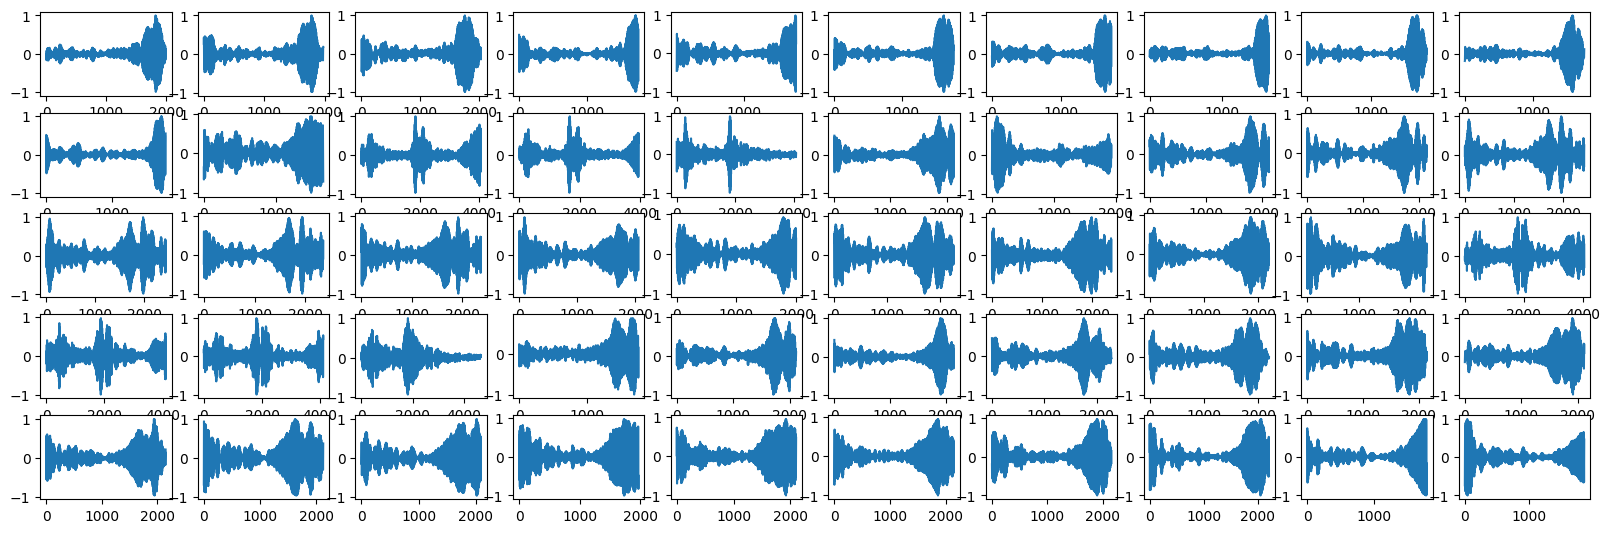

In [26]:
# looking at data making sure everything is good
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [30]:
# hyperparameters for processing the dataset
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=15000,
    butter_lowcut = 500,
    butter_highcut = 15000,
    ref_level_db = 20,
    min_level_db = -10,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)
n_jobs=-1 # change as needed on how many cpu cores u have for ur device
verbosity = 10

In [32]:
# creating dataset object 
dataset = DataSet(dataset_id, hparams = hparams)

loading json:   0%|          | 0/24 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:   10.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   11.0s finished


getting unique individuals:   0%|          | 0/24 [00:00<?, ?it/s]

In [34]:
# how many wav files?
len(dataset.data_files)

24

In [36]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [38]:
# Debugging making sure there are no empty syllables
for i, syllable in enumerate(syllables_wav):
    if syllable.size == 0:
        print(f"Empty syllable at index {i}")

In [40]:
# Creating Spectrograms

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19279152001933442s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07880640029907227s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09766960144042969s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   10.9s
[Parallel(n_job

In [42]:
# how many syllables do we have?
len(syllables_spec)

402

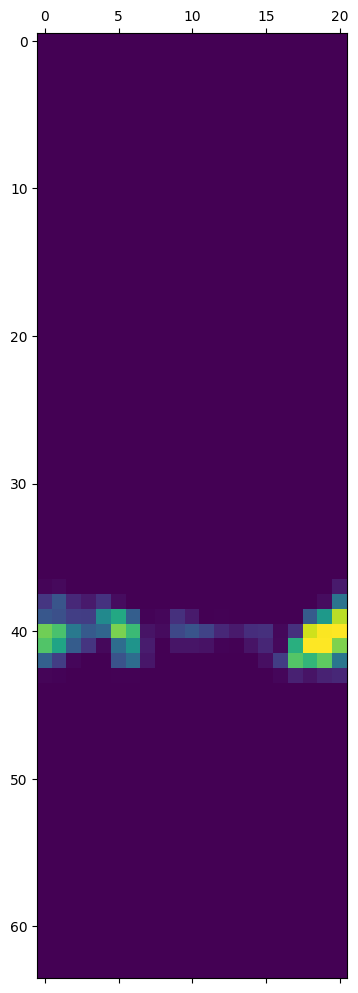

In [44]:
# plotting example, making sure everything is good 
plt.matshow(syllables_spec[10])

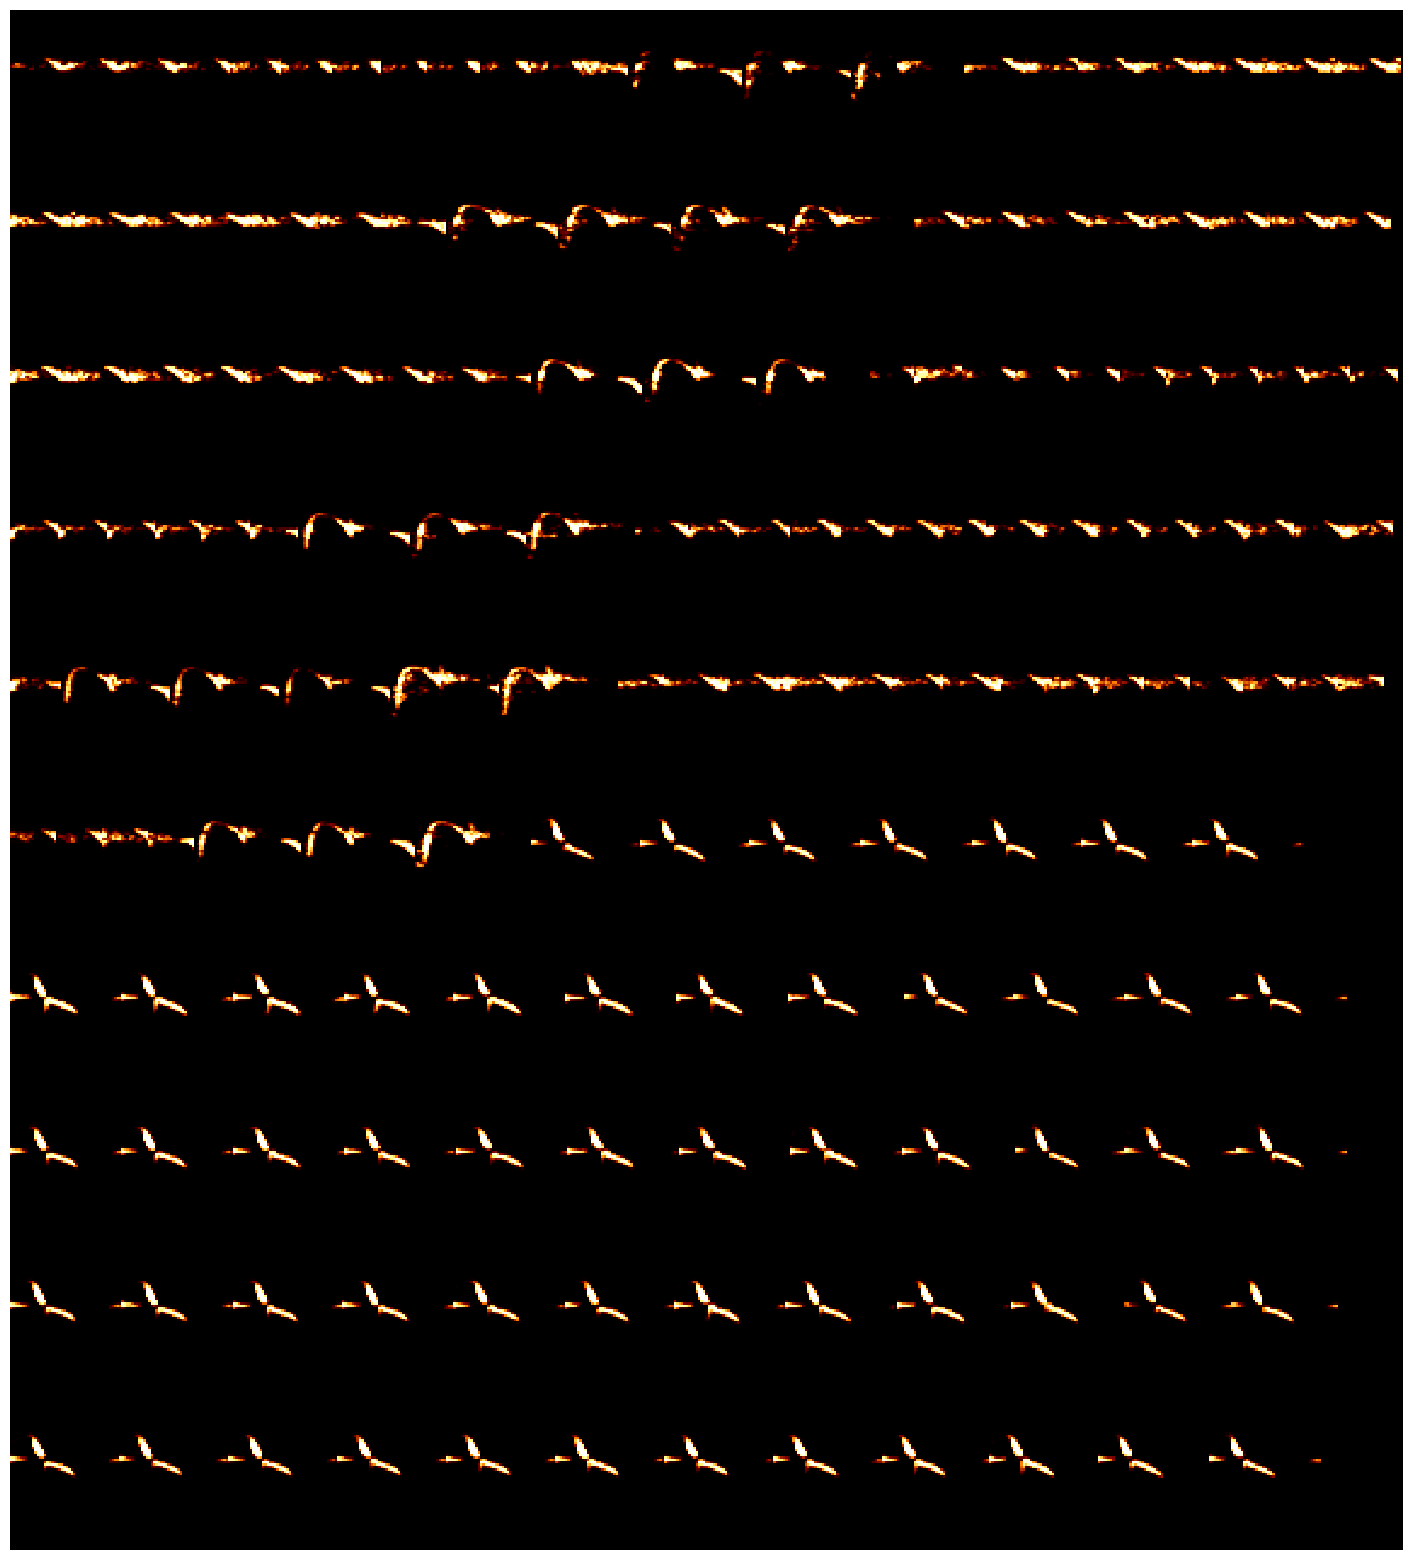

In [46]:
draw_spec_set(syllables_spec, zoom=2, maxrows=10, colsize=25)

In [48]:
# optional: logging the spectrograms
log_scaling_factor = 4
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.017716169357299805s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05179405212402344s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04659533500671387s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0581209659576416s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 353 tasks     

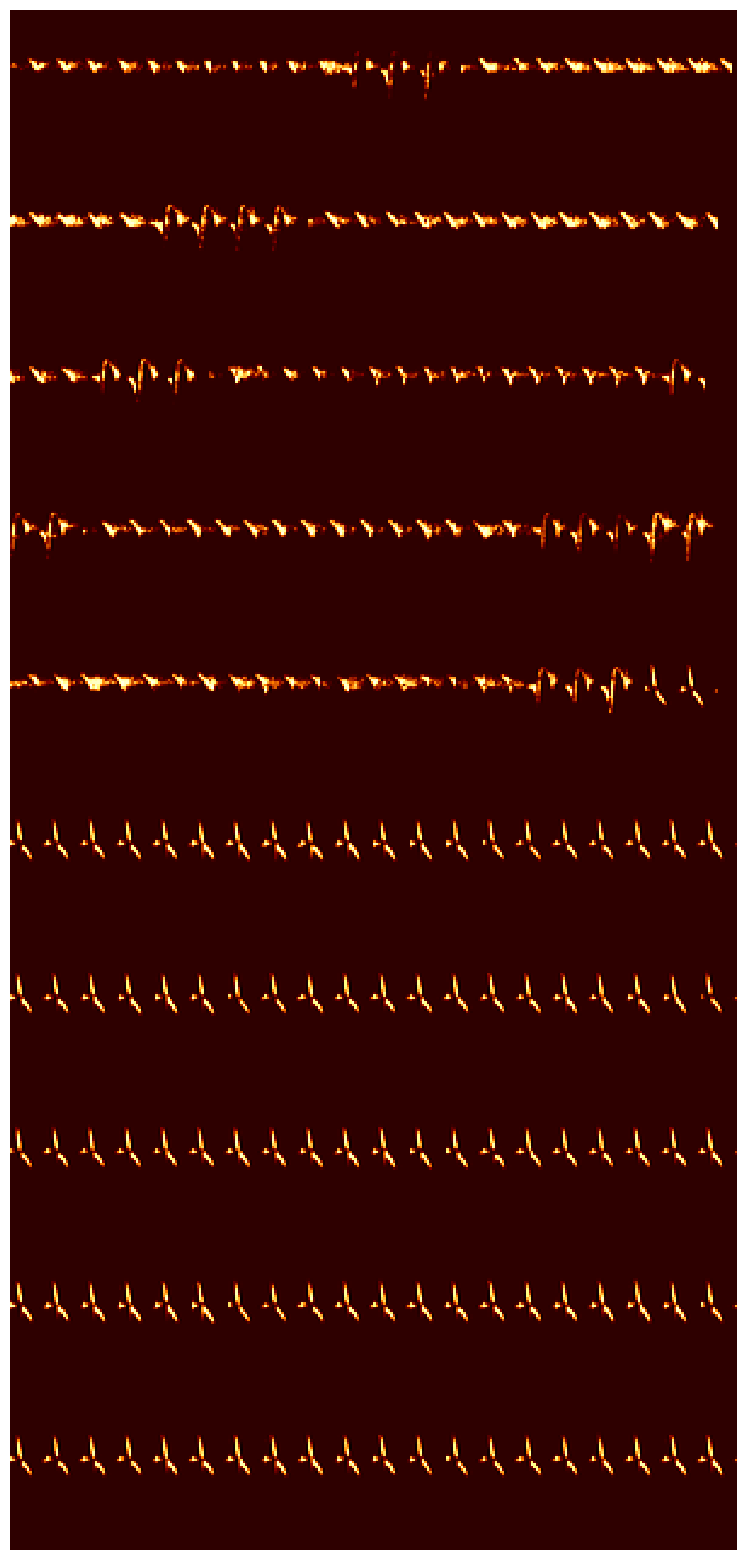

In [50]:
# looking at spectrograms making sure everything is good
draw_spec_set(syllables_spec, zoom=2, maxrows=10, colsize=25)

In [52]:
# Padding the data
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens) + 2
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

padding spectrograms:   0%|          | 0/402 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.015931129455566406s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04106307029724121s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.040421247482299805s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05759406089782715s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 353 tasks   

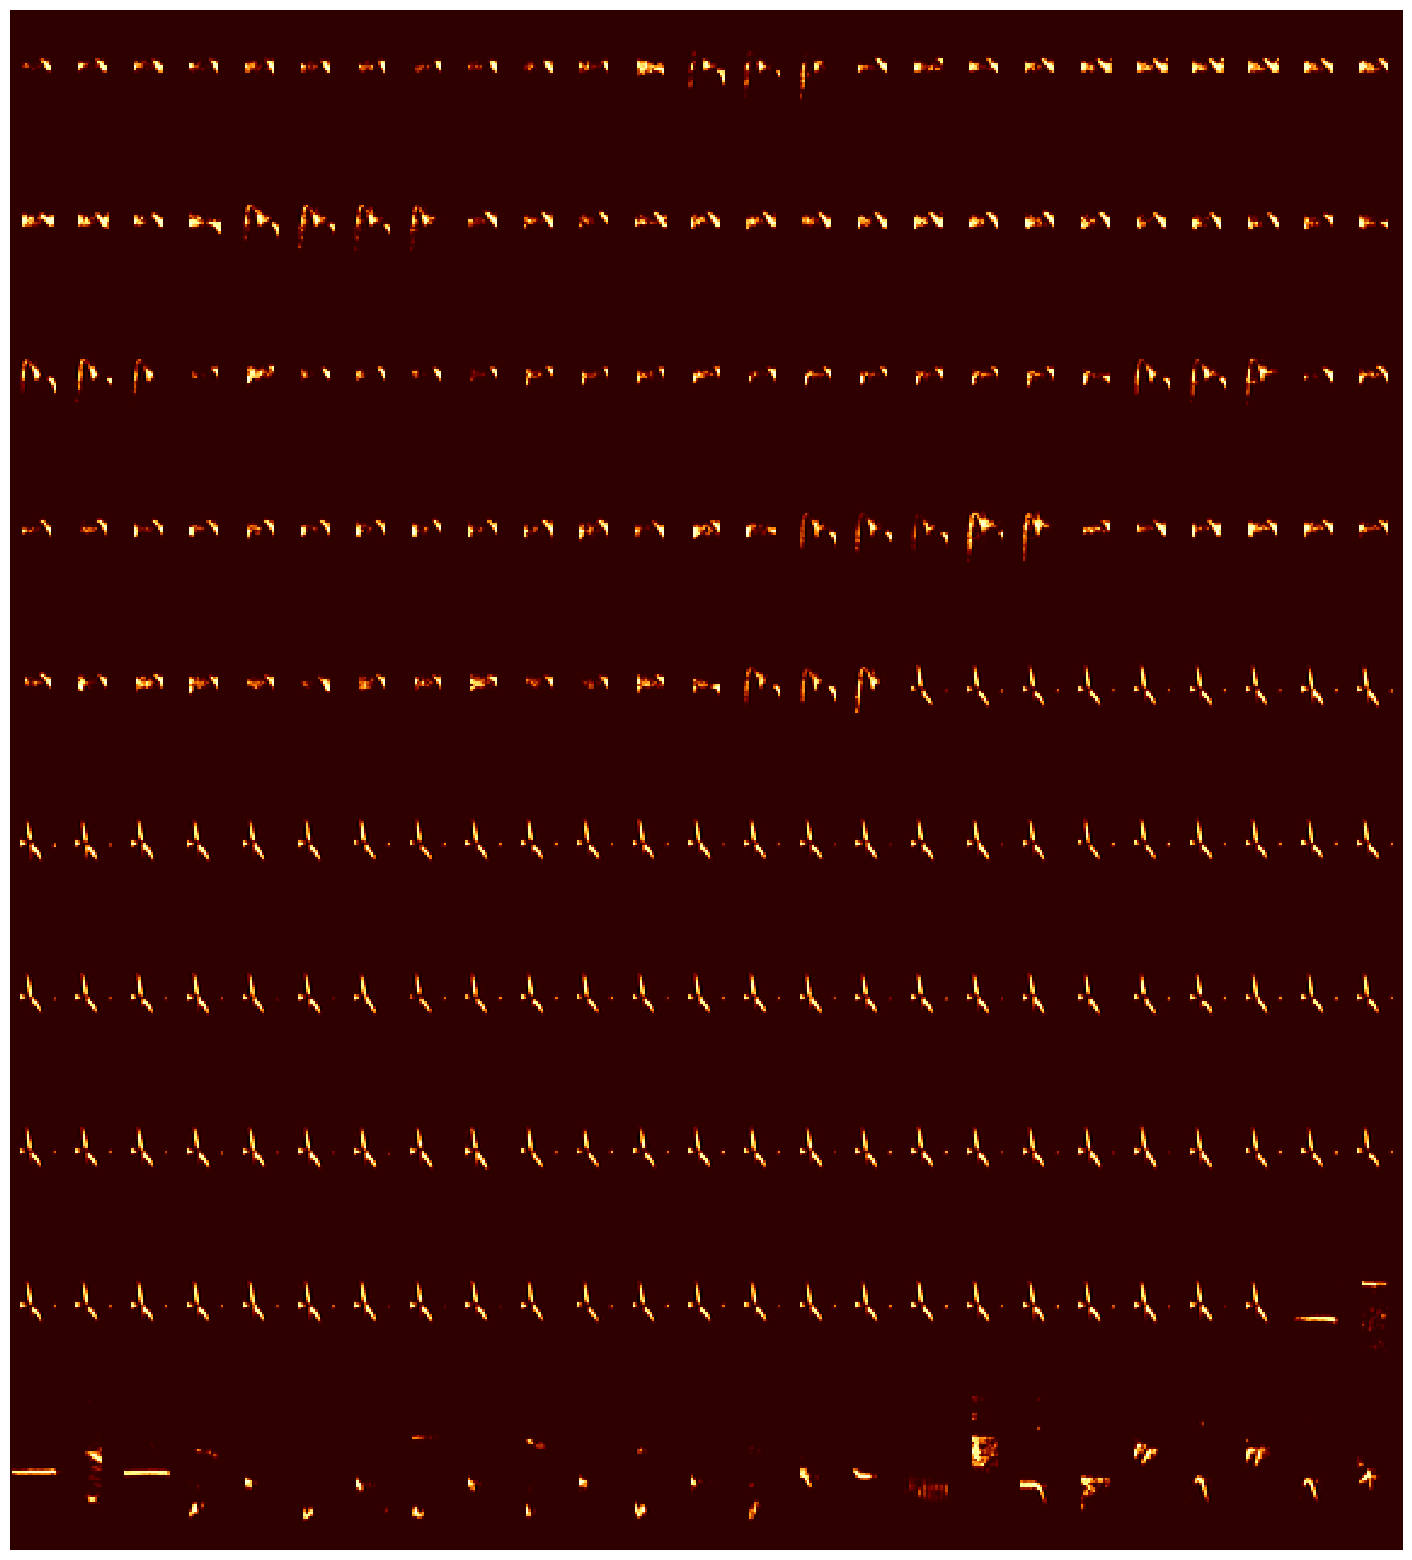

In [54]:
# looking at spectrograms making sure everything is good
draw_spec_set(syllables_spec, zoom=2, maxrows=10, colsize=25)

In [56]:
# (optional) normalize the spectrograms into uint8, to make the dataset smaller
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

  0%|          | 0/402 [00:00<?, ?it/s]

In [58]:
# Creating the spectrogram column with respective values
syllable_df['spectrogram'] = syllables_spec

In [60]:
syllable_df[:3]

,length_s,rate,wav_location,species,key,bird_id,start_time,end_time,audio,spectrogram
0,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.111429,0.156508,"[-0.011349599, -0.09828598, -0.15989809, -0.16...","[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
1,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.178730,0.223492,"[0.26540476, 0.4290777, 0.37027788, 0.12001611...","[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
2,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.245079,0.291111,"[-0.44933206, -0.42755923, -0.20444313, 0.1096...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."


In [62]:
# grabbing sequence positions using onsets and offsets

indv_dfs = []
for bird_id in tqdm(syllable_df.bird_id.unique()):
    indv_df = syllable_df[syllable_df.bird_id == bird_id]
    
    syllables_sequence_pos = np.concatenate(
        [
            np.arange(np.sum(indv_df.key == key))
            for key in indv_df.key.unique()
        ]
    )
    syllables_sequence_id = np.concatenate(
        [
            np.repeat(ki, np.sum(indv_df.key == key))
            for ki, key in enumerate(indv_df.key.unique())
        ]
    )
    indv_df.loc[:,"syllables_sequence_pos"] = syllables_sequence_pos
    indv_df.loc[:,"syllables_sequence_id"] = syllables_sequence_id
    indv_dfs.append(indv_df)
syllable_df = pd.concat(indv_dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\ramma\AppData\Local\Temp\ipykernel_27156\2148982955.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indv_df.loc[:,"syllables_sequence_pos"] = syllables_sequence_pos
C:\Users\ramma\AppData\Local\Temp\ipykernel_27156\2148982955.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indv_df.loc[:,"syllables_sequence_id"] = syllables_sequence_id
C:\Users\ramma\AppData\Local\Temp\ipykernel_27156\2148982955.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [64]:
syllable_df[:3]

,length_s,rate,wav_location,species,key,bird_id,start_time,end_time,audio,spectrogram,syllables_sequence_pos,syllables_sequence_id
0,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.111429,0.156508,"[-0.011349599, -0.09828598, -0.15989809, -0.16...","[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",0,0
1,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.178730,0.223492,"[0.26540476, 0.4290777, 0.37027788, 0.12001611...","[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...",1,0
2,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.245079,0.291111,"[-0.44933206, -0.42755923, -0.20444313, 0.1096...","[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...",2,0


### Saving the initial dataset

In [66]:
# optional:  dropping the audio column since we don't need it
syllable_df.drop('audio', axis = 1).to_pickle(save_loc)

In [68]:
# optional: saving as csv

syllable_df = pd.read_pickle(save_loc)
# Save the DataFrame to a CSV file
syllable_df.to_csv(csv_file_path, index=False)
print(f"Pickle file successfully converted to CSV and saved at: {csv_file_path}")

Pickle file successfully converted to CSV and saved at: C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds.csv


## 1.0 Nester: Clustering and Manual Corrections

### Syntaxing
In this section, you'll be able to dynamically change the umap and hdbscan parameters as well as correct it's syntaxing. You'll Also be able to save the dataframe and optionally run it through the visualizations.

In [4]:
# enable widgets
#if widget' is not a recognised GUI loop or backend name, then run 
#conda install -c conda-forge ipympl jupyterlab 
#in the terminal 

%matplotlib widget

In [5]:
## load data and make sure it looks good
syllable_df = pd.read_pickle(save_loc) #if already made edits, use the pickle_corrected pickle file
syllable_df[:3]

,length_s,rate,wav_location,species,key,bird_id,start_time,end_time,spectrogram,syllables_sequence_pos,syllables_sequence_id
0,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.111429,0.156508,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",0,0
1,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.178730,0.223492,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...",1,0
2,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.245079,0.291111,"[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...",2,0


In [7]:
############################################
## ACTIVATE NESTER BY RUNNING THIS CELL  ##
###########################################


# --- Internal state ---
edited_labels = {}
active_df = None
current_axes = None
edit_history = []

# --- Ensure new column exists ---
if 'hdbscan_syntax_label' not in syllable_df.columns:
    syllable_df['hdbscan_syntax_label'] = None

if 'final_syntax' not in syllable_df.columns:
    syllable_df['final_syntax'] = np.nan
    
# --- Save Edits Back to syllable_df ---
def save_edits_to_syllable_df():
    global active_df, bird_dropdown, syllable_df

    if active_df is None or active_df.empty:
        print("❌ No data to save: No changes made yet")
        return
    
    if 'final_syntax' not in active_df.columns:
        print("❌ 'final_syntax' column missing in dataframe.")
        return

    if 'final_syntax' not in syllable_df.columns:
        syllable_df['final_syntax'] = np.nan

    # Get current bird_id from dropdown widget
    current_bird = bird_dropdown.value
    if current_bird is None:
        print("❌ No bird selected.")
        return

    # Filter syllable_df to rows of current bird
    bird_rows = syllable_df['bird_id'] == current_bird

    # Valid indices where both active_df and syllable_df overlap for current bird only
    valid_index = active_df.index.intersection(syllable_df[bird_rows].index)

    if valid_index.empty:
        print("❌ No overlapping indices for current bird to save.")
        return

    # Save edits only for the current bird rows
    syllable_df.loc[valid_index, 'final_syntax'] = active_df.loc[valid_index, 'final_syntax'].values

    print(f"✅ Saved {len(valid_index)} editable labels into syllable_df['final_syntax'] for bird '{current_bird}'.")
        
# --- UI Controls ---
bird_dropdown = widgets.Dropdown(
    options=sorted(syllable_df['bird_id'].unique()),
    description='Bird:'
)
key_dropdown = widgets.Dropdown(description='Bout:')
umap_slider = widgets.FloatText(
    description='UMAP distance', value=0.25,
    step = 0.01,
    layout=widgets.Layout(width="250px"),
    style={'description_width': 'initial'}
)
mcs_slider = widgets.IntText(description='Cluster Size', value=5)
direction_toggle = widgets.ToggleButtons(
    options=[('↑ Increment', 1), ('↓ Decrement', -1)],
    description='Click mode:',
    style={'description_width': 'initial'}
)
plot_all_bouts_button = widgets.Button(
    description="Show All Bouts for Bird",
    layout=widgets.Layout(width="300px")
)
save_figures_button = widgets.Button(
    description="Save All Figures",
    layout=widgets.Layout(width="300px")
)
plot_output = widgets.Output()

# --- Embedding & Clustering Memory ---
bird_embeddings = {}  # bird_id → {embedded, labels, params}
per_bird_params = {}

# --- Making UMAP & HDBSCAN columns ---
if 'mcs_used' not in syllable_df.columns:
    syllable_df['hdbscan_mcs'] = 5
if 'umap_min_dist' not in syllable_df.columns:
    syllable_df['umap_min_dist'] = 0.25
seed = 1234

# --- Initializing UMAP & HDBSCAN columns ---
# Ensure the syntax label column exists
syllable_df['hdbscan_syntax_label'] = np.nan

for bird_id in syllable_df['bird_id'].unique():
    bird_df = syllable_df[syllable_df['bird_id'] == bird_id].copy()

    if bird_df.empty or 'spectrogram' not in bird_df.columns:
        print(f"⚠️ Skipping '{bird_id}' — no usable data.")
        continue

    try:
        mcs = int(bird_df['hdbscan_mcs'].iloc[0])
        min_dist = float(bird_df['umap_min_dist'].iloc[0])
    except Exception as e:
        print(f"❌ Param extraction failed for '{bird_id}': {e}")
        continue

    specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bird_df['spectrogram'].values])
    specs[specs < 0] = 0
    flat = specs.reshape(specs.shape[0], -1)

    try:
        embedded = umap.UMAP(min_dist=min_dist, random_state=seed).fit_transform(flat)
        labels = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=1).fit_predict(embedded)
        syllable_df.loc[bird_df.index, 'hdbscan_syntax_label'] = labels
    except Exception as e:
        print(f"❌ Clustering failed for '{bird_id}': {e}")

# --- Utility ---
def generate_label_colors(unique_labels, cmap_name="tab20"):
    cmap = colormaps.get_cmap(cmap_name).resampled(len(unique_labels))
    return {label: to_hex(cmap(i)) for i, label in enumerate(unique_labels)}

def save_current_params(bird_id):
    if bird_id:
        per_bird_params[bird_id] = {
            'min_dist': umap_slider.value,
            'mcs': mcs_slider.value
        }

import os

def save_all_figures_callback(_):
    bird_id = bird_dropdown.value
    if bird_id is None:
        print("No bird selected.")
        return

    # Get bird data
    bird_df = syllable_df[syllable_df['bird_id'] == bird_id].copy()
    if bird_df.empty:
        print(f"No data for bird '{bird_id}'.")
        return

    species = bird_df['species'].iloc[0]
    min_dist = umap_slider.value
    mcs = mcs_slider.value

    # Ensure global clustering exists
    if bird_id not in bird_embeddings:
        print("Clustering not available. Run 'Show All Bouts' first.")
        return

    labels = bird_embeddings[bird_id]['labels']
    bird_df['final_syntax'] = labels
    for i, val in edited_labels.items():
        if i in bird_df.index:
            bird_df.loc[i, 'final_syntax'] = val

    # Create folder
    os.makedirs(output_dir / 'corrected', exist_ok=True)
    os.makedirs(output_dir / 'corrected'/'by_bird', exist_ok=True)

    # --- Save full bird view ---
    bout_keys = sorted(bird_df['key'].unique())
    fig, axes = plt.subplots(nrows=len(bout_keys), figsize=(12, 3.5 * len(bout_keys)), sharex=False)

    if len(bout_keys) == 1:
        axes = [axes]

    for ax, key in zip(axes, bout_keys):
        bout_df = bird_df[bird_df['key'] == key]
        specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bout_df['spectrogram'].values])
        specs[specs < 0] = 0
        label_colors = generate_label_colors(np.unique(bout_df['final_syntax']))

        for i, spec in enumerate(specs):
            label = bout_df.iloc[i]['final_syntax']
            color = label_colors.get(label, '#aaa')
            ax.imshow(spec, aspect='auto', extent=[i, i+1, 0, 1], cmap='magma')
            ax.add_patch(mpatches.Rectangle((i, -0.05), 1, 0.1,
                                            facecolor=color, edgecolor='black', alpha=0.7, transform=ax.transData))
            ax.text(i + 0.5, -0.1, str(label), ha='center', va='top', fontsize=8)

        ax.axis('off')
        ax.set_xlim(0, len(specs))
        ax.set_ylim(-0.3, 1.1)
        ax.set_title(f"{species} {bird_id} | {key} | UMAP: {min_dist}, HDBSCAN: {mcs}")

    fig.tight_layout()
    fig.savefig(output_dir / 'corrected' / 'by_bird' / f"{species}_{bird_id}_ALL_BOUTS.png", dpi=150)
    plt.close(fig)

    # --- Save individual bout views ---
    for key in bout_keys:
        bout_df = bird_df[bird_df['key'] == key]
        specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bout_df['spectrogram'].values])
        specs[specs < 0] = 0
        label_colors = generate_label_colors(np.unique(bout_df['final_syntax']))

        fig, ax = plt.subplots(figsize=(12, 2))
        for i, spec in enumerate(specs):
            label = bout_df.iloc[i]['final_syntax']
            color = label_colors.get(label, '#aaa')
            ax.imshow(spec, aspect='auto', extent=[i, i+1, 0, 1], cmap='magma')
            ax.add_patch(mpatches.Rectangle((i, -0.05), 1, 0.1,
                                            facecolor=color, edgecolor='black', alpha=0.7, transform=ax.transData))
            ax.text(i + 0.5, -0.1, str(label), ha='center', va='top', fontsize=8)
        ax.axis('off')
        ax.set_xlim(0, len(specs))
        ax.set_ylim(-0.3, 1.1)
        ax.set_title(f"{species} {bird_id} | {key} | UMAP: {min_dist}, HDBSCAN: {mcs}")
        fig.tight_layout()
        fig.savefig(output_dir/ 'corrected' / f"{species}_{bird_id}_{key}.png", dpi=150)
        plt.close(fig)

    print(f"All figures saved for bird {bird_id} in output_figures/{bird_id}_{key}/")

# --- Main Plot Logic ---
def plot_all_bouts_for_bird():
    bird_id = bird_dropdown.value
    if bird_id is None:
        return

    bird_df = syllable_df[syllable_df['bird_id'] == bird_id].copy()
    if bird_df.empty:
        with plot_output:
            plot_output.clear_output(wait=True)
            print(f"No data for bird '{bird_id}'.")
        return

    # --- UMAP + HDBSCAN for full bird ---
    specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bird_df['spectrogram'].values])
    specs[specs < 0] = 0
    flat = specs.reshape(specs.shape[0], -1)

    min_dist = umap_slider.value
    mcs = mcs_slider.value
    params = {'min_dist': min_dist, 'mcs': mcs}

    cache = bird_embeddings.get(bird_id)
    if cache and cache['params'] == params:
        labels = cache['labels']
    else:
        embedded = umap.UMAP(min_dist=min_dist, random_state=seed).fit_transform(flat)
        labels = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=1).fit_predict(embedded)
        bird_embeddings[bird_id] = {'labels': labels, 'params': params}

    bird_df['final_syntax'] = labels
    for i, val in edited_labels.items():
        if i in bird_df.index:
            bird_df.loc[i, 'final_syntax'] = val

    syllable_df.loc[bird_df.index, 'hdbscan_mcs'] = mcs
    syllable_df.loc[bird_df.index, 'umap_min_dist'] = min_dist

    # --- Plot each bout row ---
    bout_keys = sorted(bird_df['key'].unique())
    if len(bout_keys) > 10:
        with plot_output:
            plot_output.clear_output(wait=True)
            print(f"⚠️ Bird '{bird_id}' has {len(bout_keys)} bouts — showing individual view instead.")
        update_plot()
        return bird_df.index, labels

    with plot_output:
        plot_output.clear_output(wait=True)
        plt.close('all')
        fig, axes = plt.subplots(nrows=len(bout_keys), figsize=(12, 3.5 * len(bout_keys)), sharex=False)
        if len(bout_keys) == 1:
            axes = [axes]

        for ax, key in zip(axes, bout_keys):
            bout_df = bird_df[bird_df['key'] == key].copy()
            specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bout_df['spectrogram'].values])
            specs[specs < 0] = 0
            label_colors = generate_label_colors(np.unique(bout_df['final_syntax']))
            for i, spec in enumerate(specs):
                label = bout_df.iloc[i]['final_syntax']
                color = label_colors.get(label, '#aaa')
                ax.imshow(spec, aspect='auto', extent=[i, i + 1, 0, 1], cmap='magma')
                ax.add_patch(mpatches.Rectangle((i, -0.05), 1, 0.1, facecolor=color,
                                                edgecolor='black', alpha=0.7, transform=ax.transData))
                ax.text(i + 0.5, -0.1, str(label), ha='center', va='top', fontsize=8, color='black')
            ax.set_xlim(0, len(specs))
            ax.set_ylim(-0.3, 1.1)
            ax.axis('off')
            species = bout_df['species'].iloc[0]
            ax.set_title(f"{species} {bird_id} | {key} | UMAP: {min_dist}, HDBSCAN: {mcs}")
        plt.tight_layout()
        plt.show()

    label_counts = bird_df['final_syntax'].value_counts().to_dict()
    with plot_output:
        print(f"\nLabels for {species} {bird_id}:")
        for label, count in sorted(label_counts.items()):
            print(f" {label}: {count}")
        print(f"\nTotal syllables: {len(bird_df)}")

    return bird_df.index, labels


# --- When calling the function ---
results = plot_all_bouts_for_bird()
if results:
    indices, labels = results
    syllable_df.loc[indices, 'final_syntax'] = labels

# --- Bout Zoom View ---
def update_plot(change=None):
    global current_axes, active_df
    bird_id = bird_dropdown.value
    key = key_dropdown.value
    if key is None:
        return

    bird_df = syllable_df[syllable_df['bird_id'] == bird_id].copy()
    if bird_id not in bird_embeddings:
        return

    labels = bird_embeddings[bird_id]['labels']
    bird_df['final_syntax'] = labels
    for i, val in edited_labels.items():
        if i in bird_df.index:
            bird_df.loc[i, 'final_syntax'] = val

    bird_df = bird_df[bird_df['key'] == key]
    if bird_df.empty:
        return

    specs = np.array([s / np.max(s) if np.max(s) > 0 else s for s in bird_df['spectrogram'].values])
    specs[specs < 0] = 0

    label_colors = generate_label_colors(np.unique(bird_df['final_syntax']))
    species = bird_df['species'].iloc[0]
    mcs = mcs_slider.value
    min_dist = umap_slider.value

    with plot_output:
        plot_output.clear_output(wait=True)
        plt.close('all')
        fig, ax = plt.subplots(figsize=(12, 2))
        fig.canvas.manager.set_window_title(f"{species}_{bird_id}_{key}")
        current_axes = ax

        for i, spec in enumerate(specs):
            label = bird_df.iloc[i]['final_syntax']
            color = label_colors.get(label, '#aaa')
            ax.imshow(spec, aspect='auto', extent=[i, i + 1, 0, 1], cmap='magma')
            ax.add_patch(mpatches.Rectangle((i, -0.05), 1, 0.1, facecolor=color,
                                            edgecolor='black', alpha=0.7, transform=ax.transData))
            ax.text(i + 0.5, -0.1, str(label), ha='center', va='top', fontsize=8, color='black')

        ax.set_xlim(0, len(specs))
        ax.set_ylim(-0.1, 1.05)
        ax.axis('off')
        ax.set_title(f"{species} | Bird {bird_id} | {key} | UMAP: {min_dist}, HDBSCAN: {mcs}")
        fig.canvas.mpl_connect("button_press_event", on_click)
        plt.show()

    # --- Summary printout ---
    label_counts = bird_df['final_syntax'].value_counts().to_dict()
    with plot_output:
        print(f"\nLabels for {species} {bird_id} {key}: {len(bird_df)} syllables")
        for label, count in sorted(label_counts.items()):
            print(f"{label}: {count}")
    

    global active_df
    active_df = bird_df

# --- Click Editing ---
def on_click(event):
    global active_df
    if current_axes is None or event.inaxes != current_axes or active_df is None:
        return

    i = int(event.xdata)
    if 0 <= i < len(active_df):
        actual_idx = active_df.index[i]
        old = active_df.loc[actual_idx, 'final_syntax']
        step = direction_toggle.value
        new = old + step if old + step >= 0 else 0

        edit_history.append((actual_idx, old))
        active_df.loc[actual_idx, 'final_syntax'] = new
        edited_labels[actual_idx] = new
        update_plot()

save_labels_button = widgets.Button(
    description="Save Labels to DataFrame",
    layout=widgets.Layout(width="300px")
)

# --- Observer Logic ---
def update_keys_for_bird(change):
    old_bird = getattr(update_keys_for_bird, 'last_bird', None)
    bird_id = change['new']
    update_keys_for_bird.last_bird = bird_id

    save_current_params(old_bird)

    if bird_id in per_bird_params:
        umap_slider.unobserve_all()
        mcs_slider.unobserve_all()
        umap_slider.value = per_bird_params[bird_id]['min_dist']
        mcs_slider.value = per_bird_params[bird_id]['mcs']
        rebind_slider_observers()

    keys = syllable_df[syllable_df['bird_id'] == bird_id]['key'].unique()
    key_dropdown.options = sorted(keys)
    key_dropdown.value = None

    plot_all_bouts_for_bird()

# --- Hook everything up ---
bird_dropdown.observe(update_keys_for_bird, names='value')
key_dropdown.observe(update_plot, names='value')
plot_all_bouts_button.on_click(lambda _: plot_all_bouts_for_bird())
save_figures_button.on_click(save_all_figures_callback)
save_labels_button.on_click(lambda _: save_edits_to_syllable_df())
def on_param_change(change):
    save_current_params(bird_dropdown.value)
    plot_all_bouts_for_bird()
    
def rebind_slider_observers():
    umap_slider.observe(on_param_change, names='value')
    mcs_slider.observe(on_param_change, names='value')
    
# Initial bind
rebind_slider_observers()

# Initialize key options and layout
update_keys_for_bird({'new': bird_dropdown.value})
display(widgets.VBox([
    widgets.HBox([bird_dropdown, key_dropdown, umap_slider, mcs_slider]),
    direction_toggle,
    plot_all_bouts_button,
    save_labels_button,
    widgets.HBox([save_figures_button]),
    plot_output
]))

update_plot()
if active_df is not None:
    syllable_df.loc[active_df.index, 'hdbscan_syntax_label'] = active_df['final_syntax']

***After running corrections simply save here:***

In [17]:
# CSV
syllable_df.to_csv(csv_path_corrected, index=False)
print(f"CSV file saved at: {csv_path_corrected}")

CSV file saved at: C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.csv


In [18]:
# Pickle

syllable_df.to_pickle(pickle_corrected)
print(f"Pickle file successfully converted to CSV and saved at: {pickle_corrected}")

Pickle file successfully converted to CSV and saved at: C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.pickle


***Run the next code block to fill in the syntax of those you did not edit with the original syntax provided by hdbscan (i.e. filling NaN values in final_syntax with values in hdbscan_syntax_labels.***

In [19]:
# After editing the entire Dataframe, finalize changes here and save it again:
syllable_df['final_syntax'] = syllable_df['final_syntax'].where(~syllable_df['final_syntax'].isna(), syllable_df['hdbscan_syntax_label'])

In [20]:
# CSV
syllable_df.to_csv(csv_path_corrected, index=False)
print(f"CSV file saved at: {csv_path_corrected}")

CSV file saved at: C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.csv


In [21]:
# Pickle

syllable_df.to_pickle(pickle_corrected)
print(f"Pickle file successfully converted to CSV and saved at: {pickle_corrected}")

Pickle file successfully converted to CSV and saved at: C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\tutorial-birds_corrected.pickle


## 1.5 Visualizations 

***Loading the data***

In [4]:
syllable_df = pd.read_pickle(pickle_corrected)
syllable_df[:3]

,length_s,rate,wav_location,species,key,bird_id,start_time,end_time,spectrogram,syllables_sequence_pos,syllables_sequence_id,hdbscan_syntax_label,final_syntax,hdbscan_mcs,umap_min_dist
0,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.111429,0.156508,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",0,0,1.0,1.0,5,0.25
1,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.178730,0.223492,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,...",1,0,1.0,1.0,5,0.25
2,1.126032,44100,tutorial_birds_dataset\Junco-hyemalis-139623_F...,Junco-hyemalis,bout1,139623,0.245079,0.291111,"[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...",2,0,1.0,1.0,5,0.25


### Umap Projections

***Per bird UMAP Projection***

Processing Birds:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Bird ID: 103315, Species: Pipilo-maculatus, Count: 73
UMAP(min_dist=np.float64(0.2), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:32:46 2025 Construct fuzzy simplicial set
Mon Jun 23 13:32:46 2025 Finding Nearest Neighbors
Mon Jun 23 13:32:46 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:32:46 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:32:46 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\indiv_mapping\Individual_mapping_Pipilo-maculatus_103315_RST.png
Processing Bird ID: 139623, Species: Junco-hyemalis, Count: 116
UMAP(min_dist=np.float64(0.25), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:32:48 2025 Construct fuzzy simplicial set
Mon Jun 23 13:32:48 2025 Finding Nearest Neighbors
Mon Jun 23 13:32:48 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:32:48 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:32:48 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\indiv_mapping\Individual_mapping_Junco-hyemalis_139623_RST.png
Processing Bird ID: 775292, Species: Luscinia-megarhynchos, Count: 106
UMAP(min_dist=np.float64(0.25), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:32:51 2025 Construct fuzzy simplicial set
Mon Jun 23 13:32:51 2025 Finding Nearest Neighbors
Mon Jun 23 13:32:51 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:32:51 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:32:51 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\indiv_mapping\Individual_mapping_Luscinia-megarhynchos_775292_RST.png
Processing Bird ID: 79618, Species: Junco-hyemalis, Count: 107
UMAP(min_dist=np.float64(0.25), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:32:53 2025 Construct fuzzy simplicial set
Mon Jun 23 13:32:53 2025 Finding Nearest Neighbors
Mon Jun 23 13:32:53 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:32:53 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:32:54 2025 Finished embedding


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\indiv_mapping\Individual_mapping_Junco-hyemalis_79618_RST.png


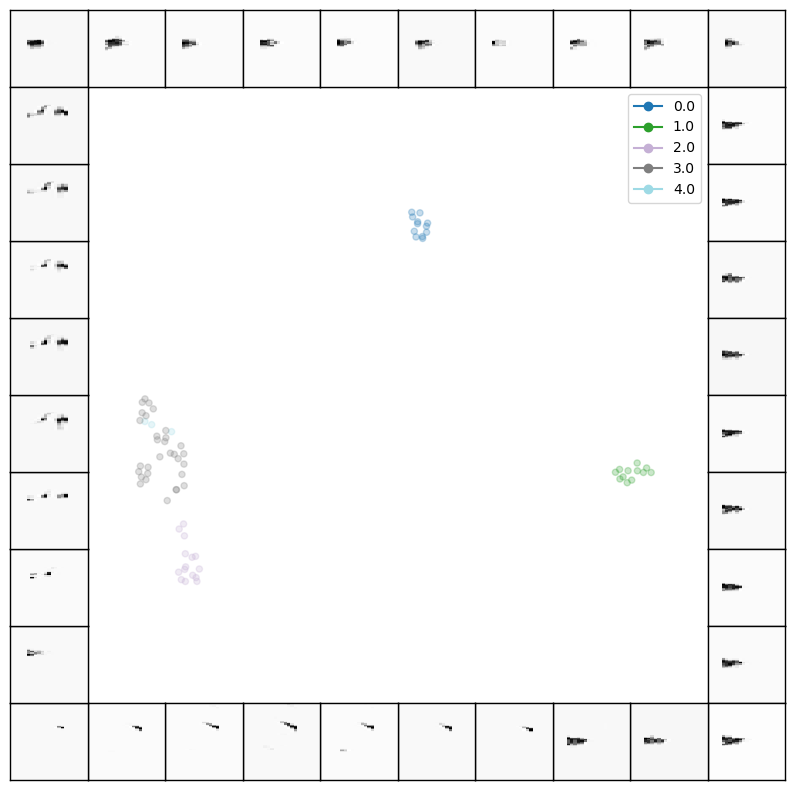

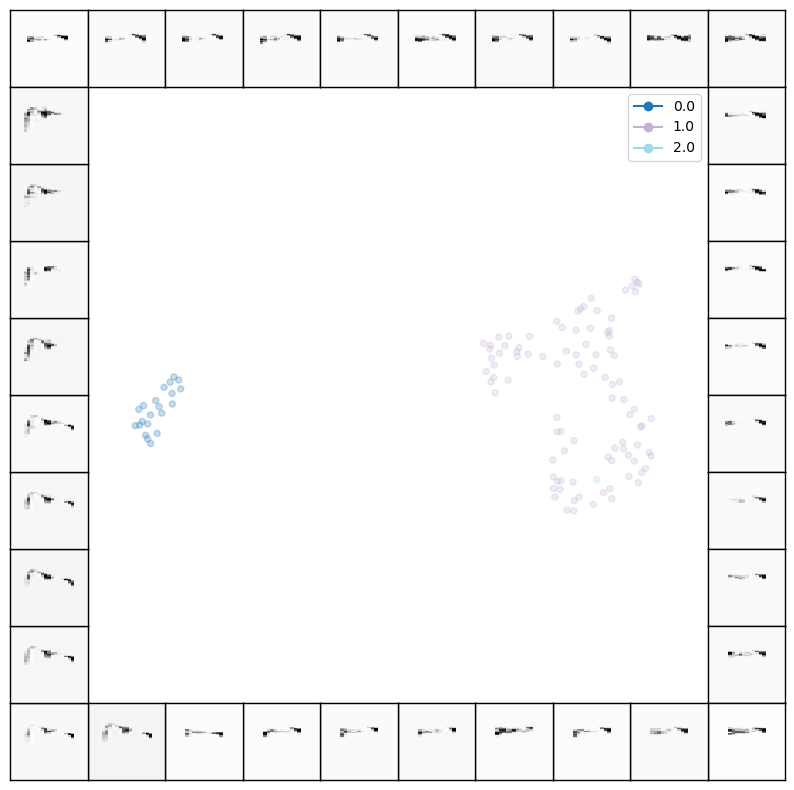

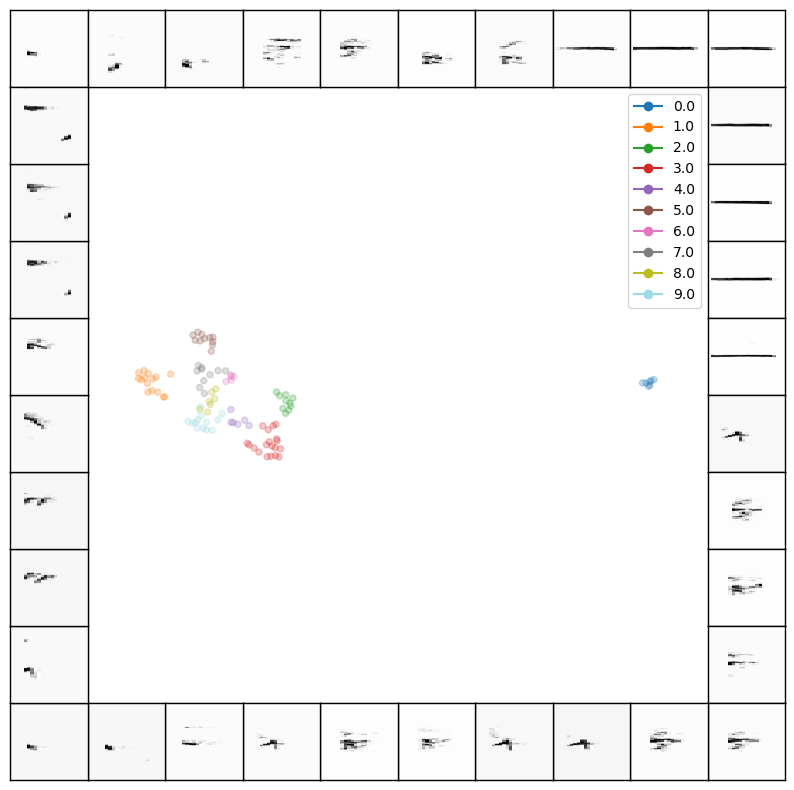

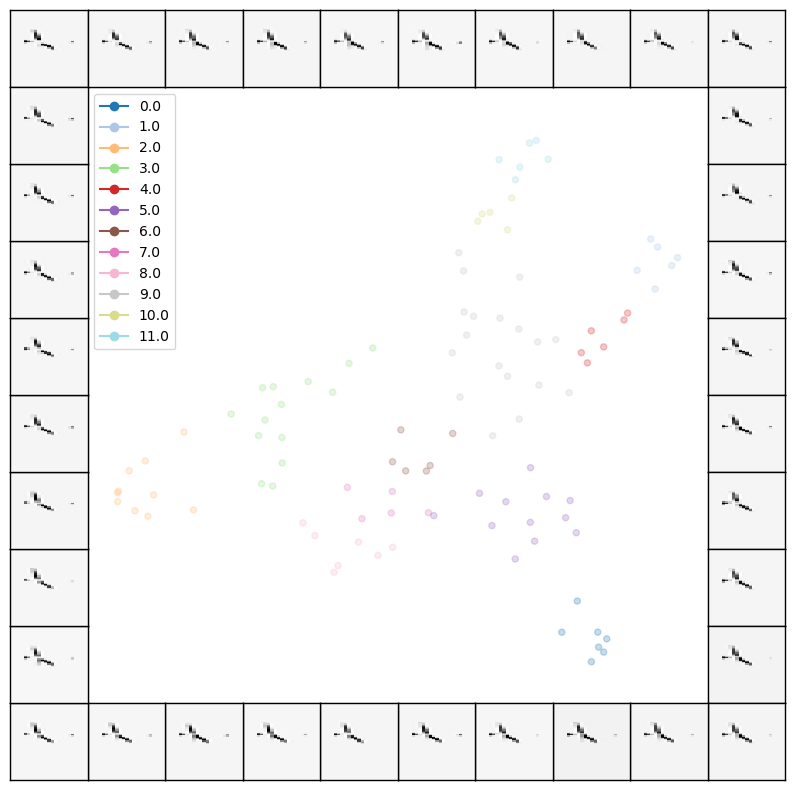

In [7]:
# Loop through unique bird IDs in the DataFrame
for bird_id in tqdm(np.sort(syllable_df.bird_id.unique()), desc="Processing Birds"):
    # Get the species corresponding to the bird ID
    species = syllable_df[syllable_df.bird_id == bird_id].species.unique()[0]
    print(f"Processing Bird ID: {bird_id}, Species: {species}, Count: {np.sum(syllable_df.bird_id == bird_id)}")
    
    # Filter the DataFrame for the current bird ID and exclude noise
    bird_df = syllable_df[(syllable_df.bird_id == bird_id) & (syllable_df.final_syntax != -1)]
    
    if bird_df.empty:
        print(f"No valid data for Bird ID: {bird_id}, skipping.")
        continue
    
    # Normalize and extract spectrograms
    specs = np.array([
        i / np.max(i) if np.max(i) > 0 else np.zeros_like(i)
        for i in bird_df.spectrogram.values
    ])
    
    # Check for consistent spectrogram shapes
    shapes = [np.shape(i) for i in bird_df.spectrogram.values]
    if len(set(shapes)) > 1:
        print(f"Inconsistent spectrogram shapes for Bird ID: {bird_id}, skipping.")
        continue
    
    # Flatten the spectrograms into 1D
    try:
        specs_flattened = flatten_spectrograms(specs)
    except ValueError as e:
        print(f"Error flattening spectrograms for Bird ID: {bird_id}: {e}")
        continue
    
    # Dropping NaN rows
    valid_mask = ~np.isnan(specs_flattened).any(axis=1)
    specs_flattened_clean = specs_flattened[valid_mask]
    
    if specs_flattened_clean.size == 0:
        print(f"All spectrograms are invalid for Bird ID: {bird_id}, skipping.")
        continue
    
    # Project (you can choose different UMAP parameters here)
    # Use value from column if available, fallback to global umap_min_dist
    bird_umap_dist = bird_df['umap_min_dist'].dropna().unique()
    if len(bird_umap_dist) == 1:
        umap_dist_used = bird_umap_dist[0]
    else:
        umap_dist_used = umap_min_dist  # fallback

    umap_n_neighbors = 10 #change if you want
    
    fit = umap.UMAP(min_dist=umap_dist_used, verbose=True, random_state=1234, n_neighbors=umap_n_neighbors)
    z = fit.fit_transform(specs_flattened_clean)
    z = np.vstack(z)
    
    # Ensure labels and projections match dimensions
    labels = bird_df['final_syntax'].values
    if len(labels) != len(z):
        print(f"Mismatch in dimensions for Bird ID: {bird_id}: labels={len(labels)}, projections={len(z)}, skipping.")
        continue

    # Create a scatterplot of the projections
    scatter_spec(
        z,
        specs,
        column_size=10,
        pal_color="tab20",
        color_points=False,
        enlarge_points=0,
        figsize=(10, 10),
        scatter_kwargs={
            'labels': labels,
            'alpha': 0.25,
            's': 20,
            'show_legend': True
        },
        matshow_kwargs={
            'cmap': plt.cm.Greys
        },
        line_kwargs={
            'lw': 1,
            'ls': "dashed",
            'alpha': 0.25,
        },
        draw_lines=False,
        n_subset = 1000,
    )
    
    # Save the plot with bird ID and species in the filename
    output_path = os.path.join(output_dir / dataset_id /'umap'/'indiv_mapping', f"Individual_mapping_{species}_{bird_id}_RST.png")
    os.makedirs(output_dir / dataset_id /'umap'/'indiv_mapping', exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Saved figure for Bird ID: {bird_id}, Species: {species} at {output_path}")

***By Species Colored by Bird***

*If you want to change it to colored by Cluster simply change 'labels' in skatterkwargs to hdbscan_mcs*

Processing Species:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Species: Junco-hyemalis, Count: 223
UMAP(min_dist=np.float64(0.25), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:41:16 2025 Construct fuzzy simplicial set
Mon Jun 23 13:41:16 2025 Finding Nearest Neighbors
Mon Jun 23 13:41:16 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:41:16 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:41:16 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\species_mapping\Species_mapping_Junco-hyemalis_RST.png
Processing Species: Luscinia-megarhynchos, Count: 106
UMAP(min_dist=np.float64(0.25), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:41:18 2025 Construct fuzzy simplicial set
Mon Jun 23 13:41:18 2025 Finding Nearest Neighbors
Mon Jun 23 13:41:18 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:41:18 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:41:19 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\species_mapping\Species_mapping_Luscinia-megarhynchos_RST.png
Processing Species: Pipilo-maculatus, Count: 73
UMAP(min_dist=np.float64(0.2), n_jobs=1, n_neighbors=10, random_state=1234, verbose=True)
Mon Jun 23 13:41:21 2025 Construct fuzzy simplicial set
Mon Jun 23 13:41:21 2025 Finding Nearest Neighbors
Mon Jun 23 13:41:21 2025 Finished Nearest Neighbor Search
Mon Jun 23 13:41:21 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 13:41:21 2025 Finished embedding


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved figure for Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\umap\species_mapping\Species_mapping_Pipilo-maculatus_RST.png


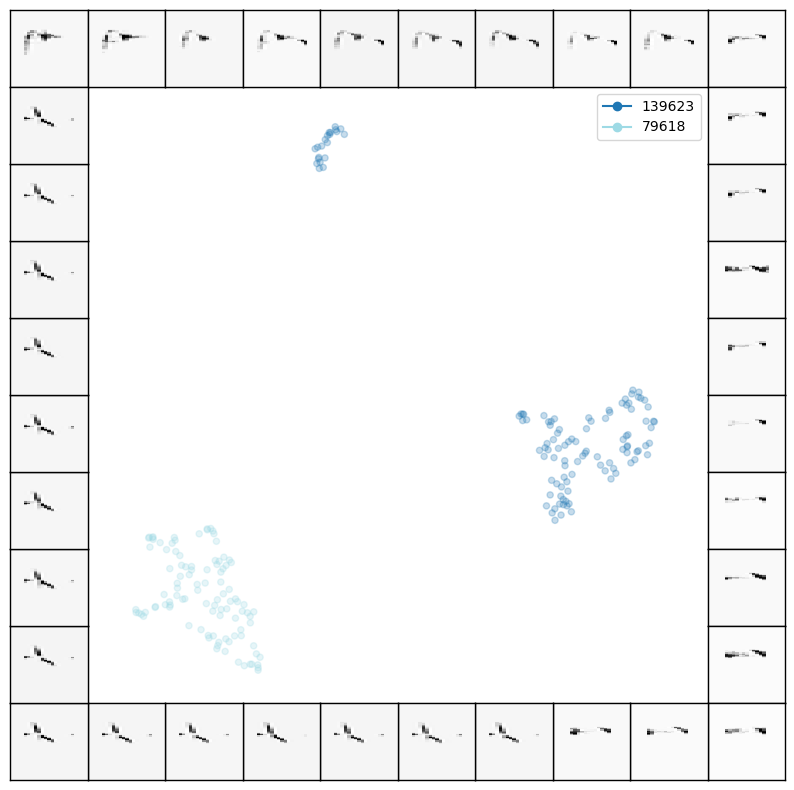

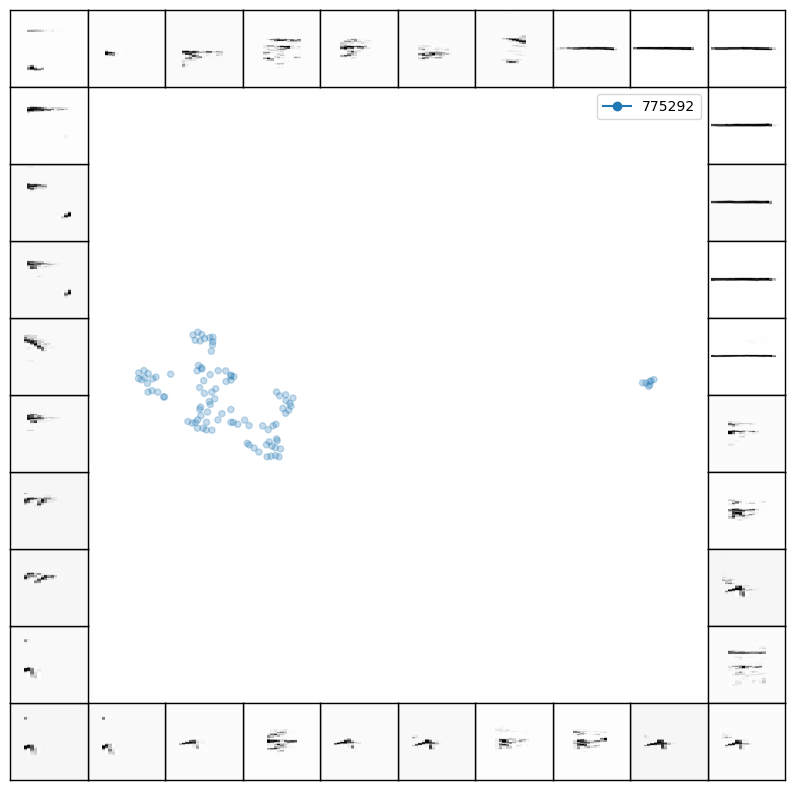

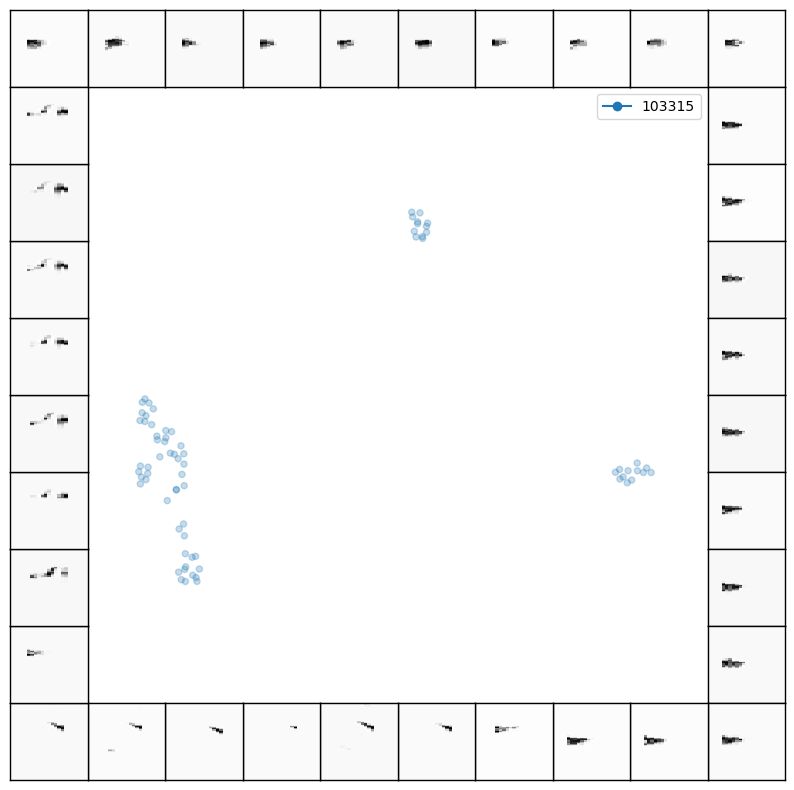

In [15]:
# Loop through unique species in the DataFrame
for species in tqdm(np.sort(syllable_df.species.unique()), desc="Processing Species"):
    print(f"Processing Species: {species}, Count: {np.sum(syllable_df.species == species)}")
    
    # Filter the DataFrame for the current species and exclude noise
    species_df = syllable_df[(syllable_df.species == species) & (syllable_df.final_syntax != -1)]
    
    if species_df.empty:
        print(f"No valid data for Species: {species}, skipping.")
        continue
    
    # Normalize and extract spectrograms
    specs = np.array([
        i / np.max(i) if np.max(i) > 0 else np.zeros_like(i)
        for i in species_df.spectrogram.values
    ])
    
    # Check for consistent spectrogram shapes
    shapes = [np.shape(i) for i in species_df.spectrogram.values]
    if len(set(shapes)) > 1:
        print(f"Inconsistent spectrogram shapes for Species: {species}, skipping.")
        continue
    
    # Flatten the spectrograms into 1D
    try:
        specs_flattened = flatten_spectrograms(specs)
    except ValueError as e:
        print(f"Error flattening spectrograms for Species: {species}: {e}")
        continue
    
    # Dropping NaN rows
    valid_mask = ~np.isnan(specs_flattened).any(axis=1)
    specs_flattened_clean = specs_flattened[valid_mask]
    
    if specs_flattened_clean.size == 0:
        print(f"All spectrograms are invalid for Species: {species}, skipping.")
        continue
    
    # Project (you can choose different UMAP parameters here)
    # Use value from column if available, fallback to global umap_min_dist
    species_umap_dist = species_df['umap_min_dist'].dropna().unique()
    if len(species_umap_dist) == 1:
        umap_dist_used = species_umap_dist[0]
    else:
        umap_dist_used = umap_min_dist  # fallback

    umap_n_neighbors = 10  # change if you want
    
    fit = umap.UMAP(min_dist=umap_dist_used, verbose=True, random_state=1234, n_neighbors=umap_n_neighbors)
    z = fit.fit_transform(specs_flattened_clean)
    z = np.vstack(z)
    
    # Ensure labels and projections match dimensions
    labels = species_df['final_syntax'].values
    bird = species_df['bird_id'].values
    if len(labels) != len(z):
        print(f"Mismatch in dimensions for Species: {species}: labels={len(labels)}, projections={len(z)}, skipping.")
        continue

    # Create a scatterplot of the projections
    scatter_spec(
        z,
        specs,
        column_size=10,
        pal_color="tab20",
        color_points=False,
        enlarge_points=0,
        figsize=(10, 10),
        scatter_kwargs={
            'labels': bird,
            'alpha': 0.25,
            's': 20,
            'show_legend': True
        },
        matshow_kwargs={
            'cmap': plt.cm.Greys
        },
        line_kwargs={
            'lw': 1,
            'ls': "dashed",
            'alpha': 0.25,
        },
        draw_lines=False,
        n_subset=1000,
    )
    
    # Save the plot with species in the filename
    output_path = os.path.join(output_dir / dataset_id / 'umap' / 'species_mapping', f"Species_mapping_{species}_RST.png")
    os.makedirs(output_dir / dataset_id / 'umap' / 'species_mapping', exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"Saved figure for Species: {species} at {output_path}")

### Colorcoded Spectrograms according to Syntaxing

***Saving by Bird by Bout***

Species: Junco-hyemalis, Total Entries: 223
  Bird ID: 139623, Entries: 116
    Bout Key: bout1, Entries: 15
      Drawing spectrograms for Bout Key: bout1...


C:\Users\ramma\AppData\Local\Temp\ipykernel_12944\254358993.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(unique_labels))


Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout1_RST.png


<Figure size 4500x200 with 0 Axes>

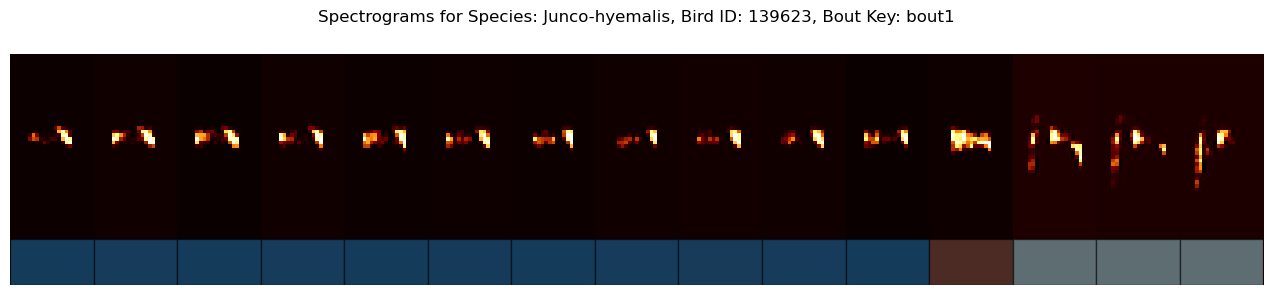

    Bout Key: bout2, Entries: 18
      Drawing spectrograms for Bout Key: bout2...
Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout2_RST.png


<Figure size 5400x200 with 0 Axes>

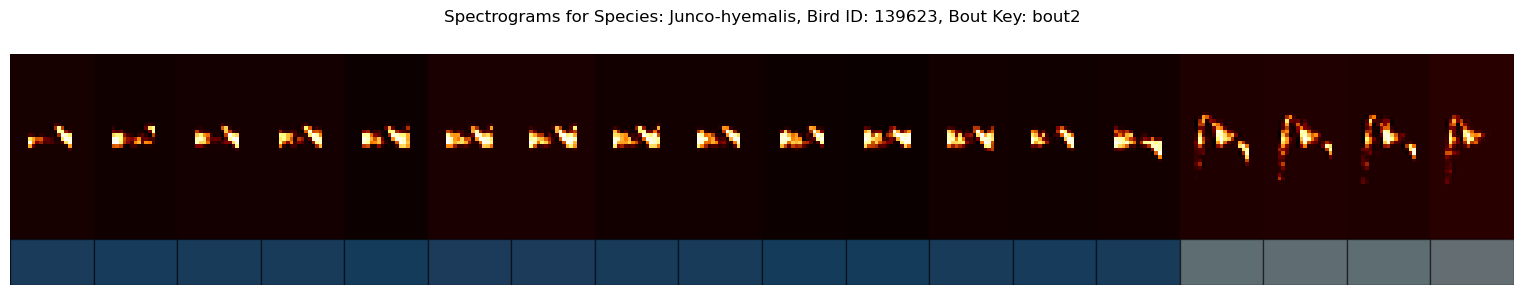

    Bout Key: bout3, Entries: 20
      Drawing spectrograms for Bout Key: bout3...
Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout3_RST.png


<Figure size 6000x200 with 0 Axes>

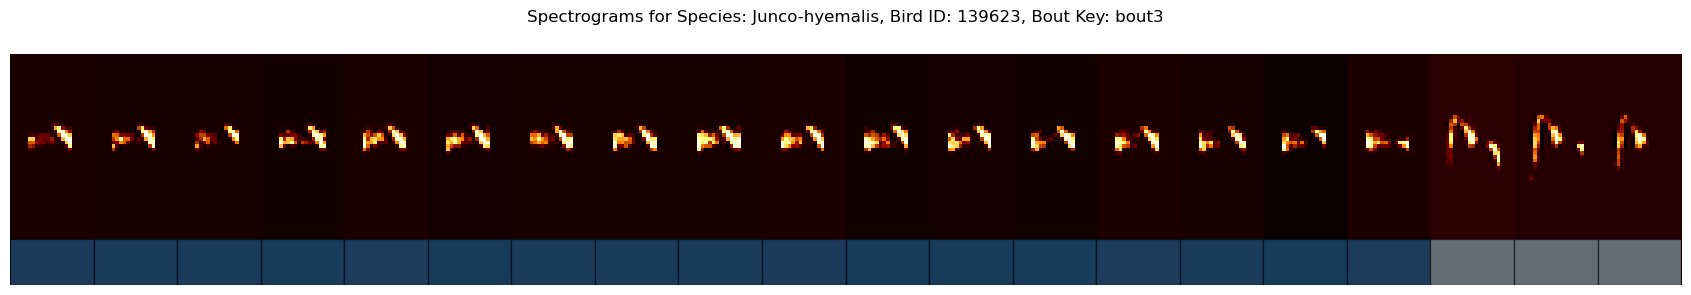

    Bout Key: bout4, Entries: 20
      Drawing spectrograms for Bout Key: bout4...
Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout4_RST.png


<Figure size 6000x200 with 0 Axes>

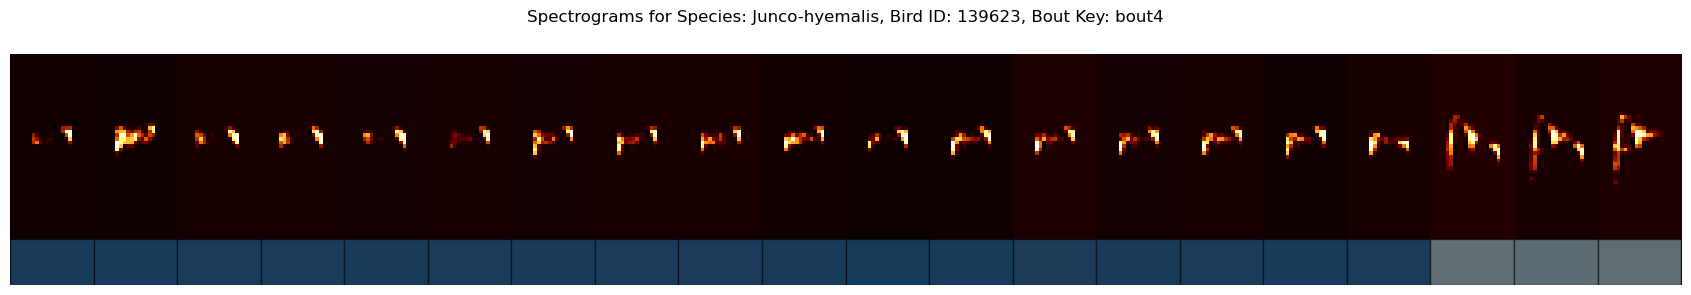

    Bout Key: bout5, Entries: 21
      Drawing spectrograms for Bout Key: bout5...
Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout5_RST.png


<Figure size 6300x200 with 0 Axes>

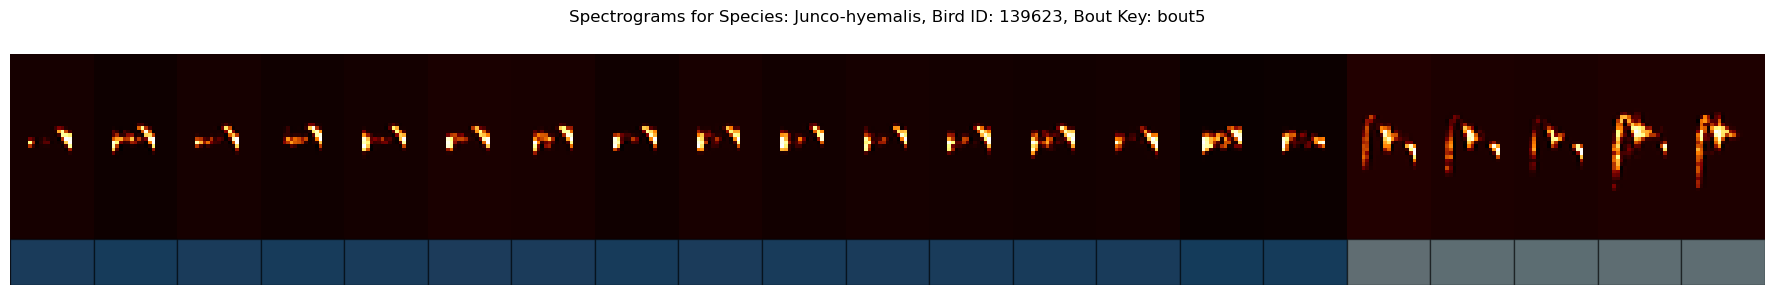

    Bout Key: bout6, Entries: 22
      Drawing spectrograms for Bout Key: bout6...
Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_139623_bout6_RST.png


<Figure size 6600x200 with 0 Axes>

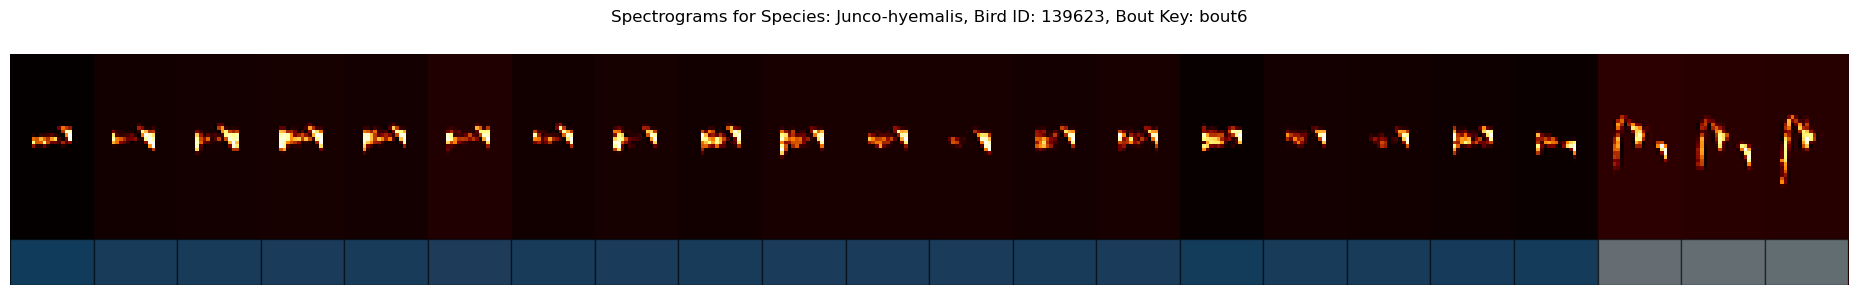

  Bird ID: 79618, Entries: 107
    Bout Key: bout1, Entries: 15
      Drawing spectrograms for Bout Key: bout1...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout1_RST.png


<Figure size 4500x200 with 0 Axes>

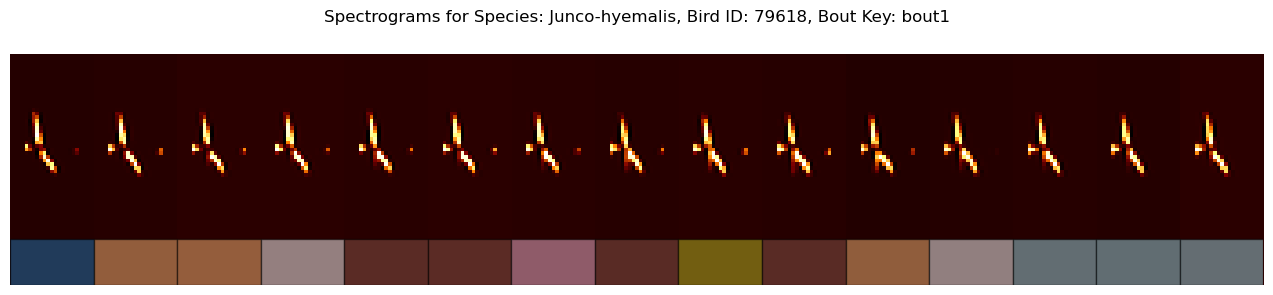

    Bout Key: bout2, Entries: 13
      Drawing spectrograms for Bout Key: bout2...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout2_RST.png


<Figure size 3900x200 with 0 Axes>

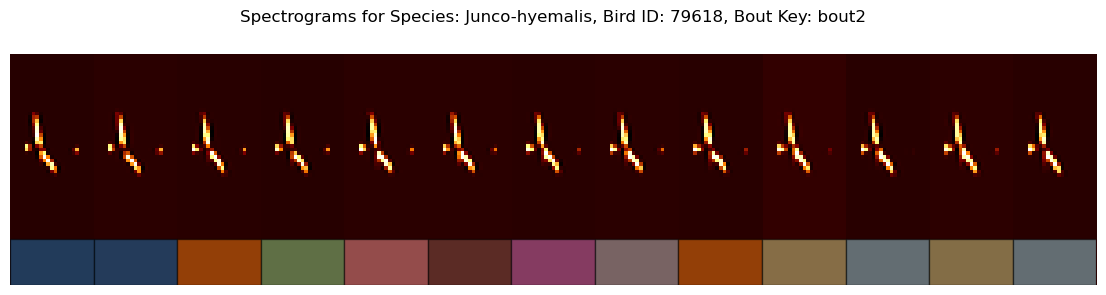

    Bout Key: bout3, Entries: 13
      Drawing spectrograms for Bout Key: bout3...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout3_RST.png


<Figure size 3900x200 with 0 Axes>

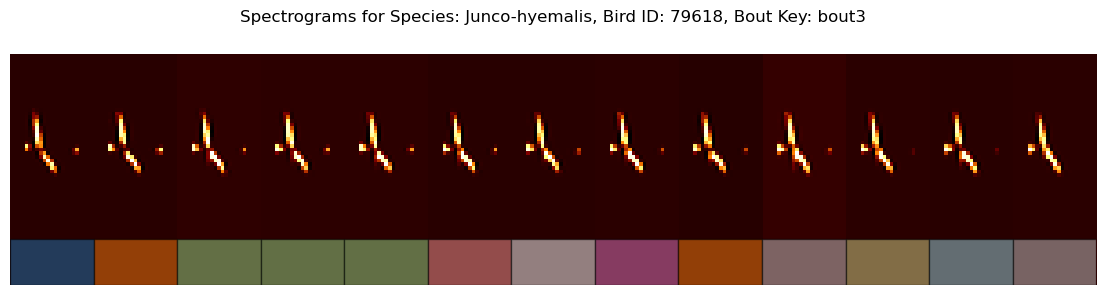

    Bout Key: bout4, Entries: 13
      Drawing spectrograms for Bout Key: bout4...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout4_RST.png


<Figure size 3900x200 with 0 Axes>

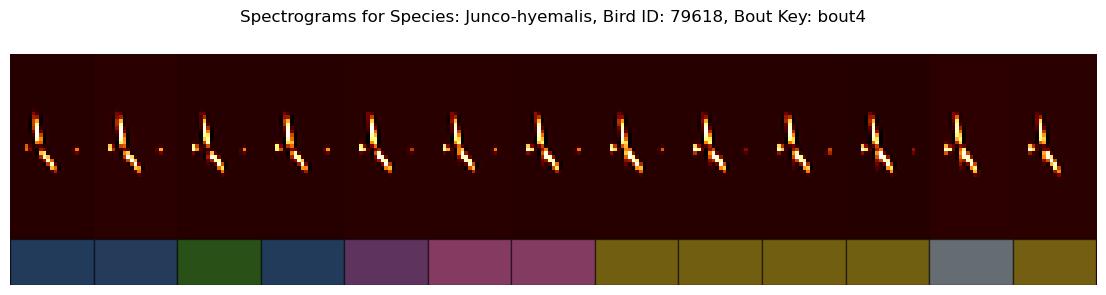

    Bout Key: bout5, Entries: 14
      Drawing spectrograms for Bout Key: bout5...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout5_RST.png


<Figure size 4200x200 with 0 Axes>

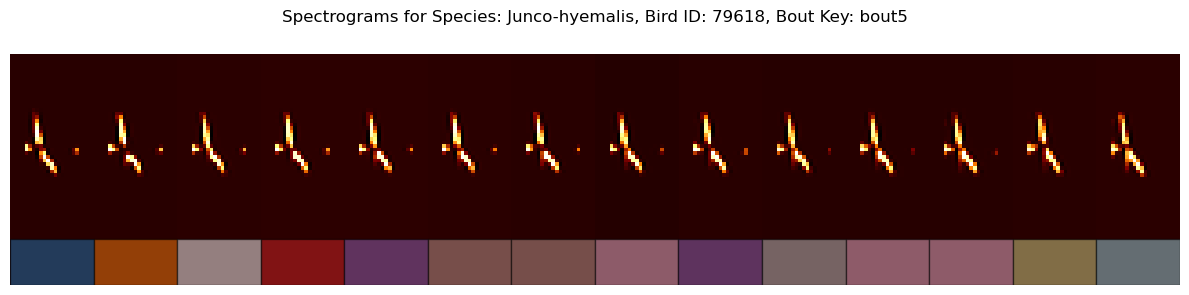

    Bout Key: bout6, Entries: 13
      Drawing spectrograms for Bout Key: bout6...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout6_RST.png


<Figure size 3900x200 with 0 Axes>

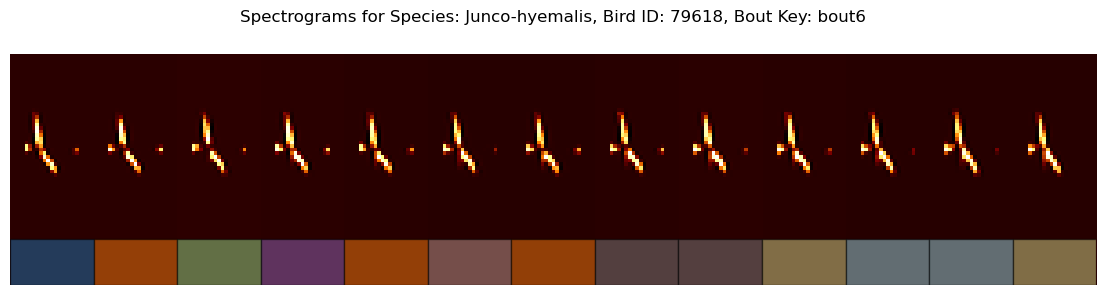

    Bout Key: bout7, Entries: 13
      Drawing spectrograms for Bout Key: bout7...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout7_RST.png


<Figure size 3900x200 with 0 Axes>

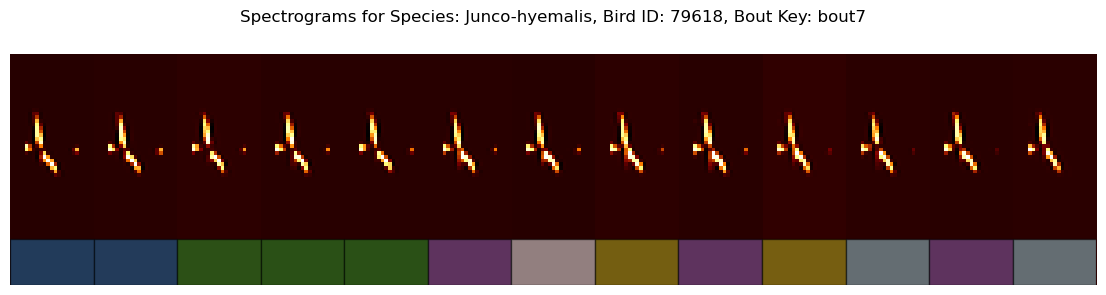

    Bout Key: bout8, Entries: 13
      Drawing spectrograms for Bout Key: bout8...
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Junco-hyemalis_79618_bout8_RST.png


<Figure size 3900x200 with 0 Axes>

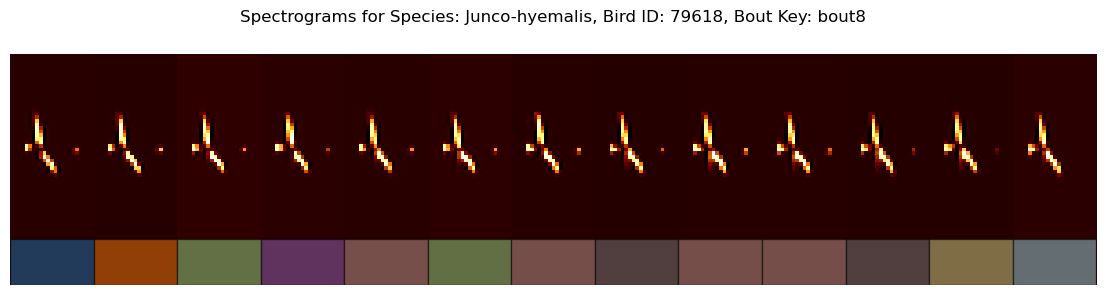

Species: Luscinia-megarhynchos, Total Entries: 106
  Bird ID: 775292, Entries: 106
    Bout Key: bout1, Entries: 17
      Drawing spectrograms for Bout Key: bout1...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_bout1_RST.png


<Figure size 5100x200 with 0 Axes>

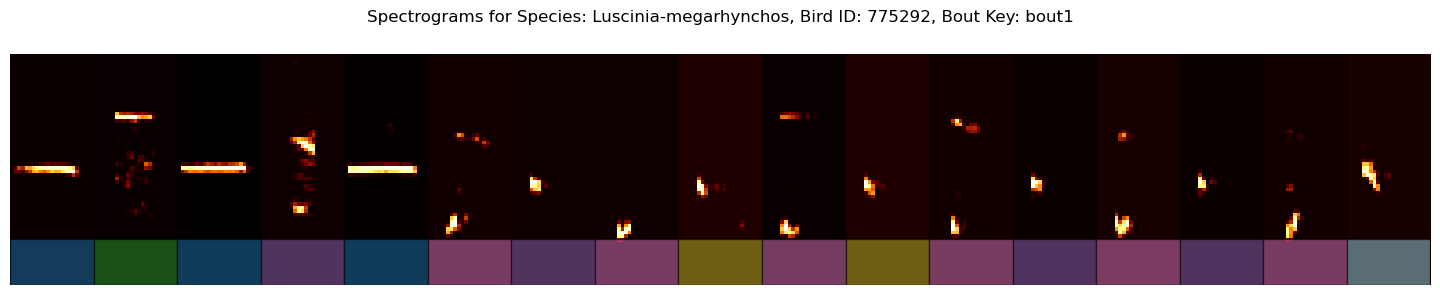

    Bout Key: bout2, Entries: 24
      Drawing spectrograms for Bout Key: bout2...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_bout2_RST.png


<Figure size 7200x200 with 0 Axes>

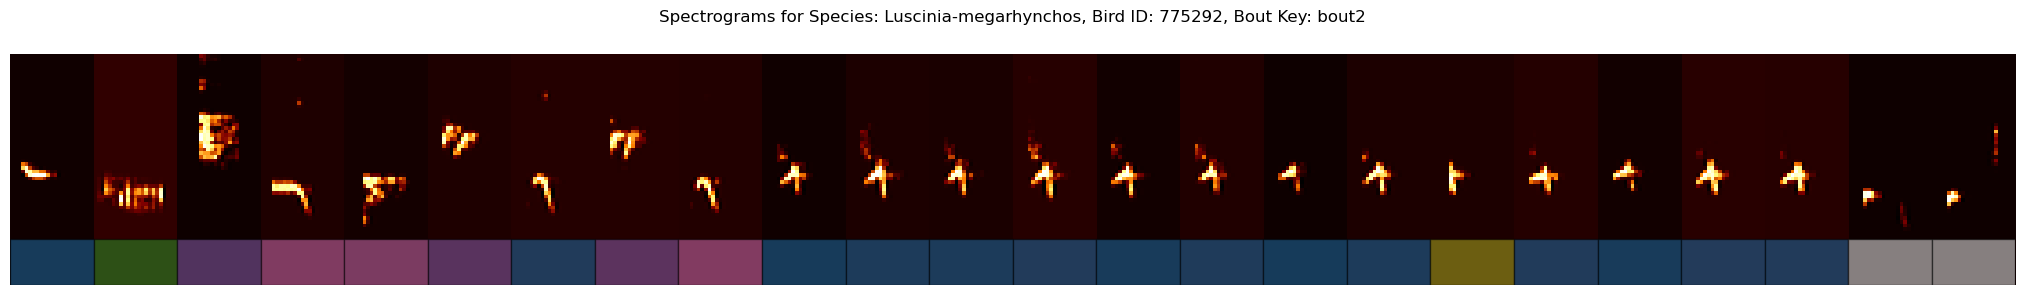

    Bout Key: bout3, Entries: 16
      Drawing spectrograms for Bout Key: bout3...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_bout3_RST.png


<Figure size 4800x200 with 0 Axes>

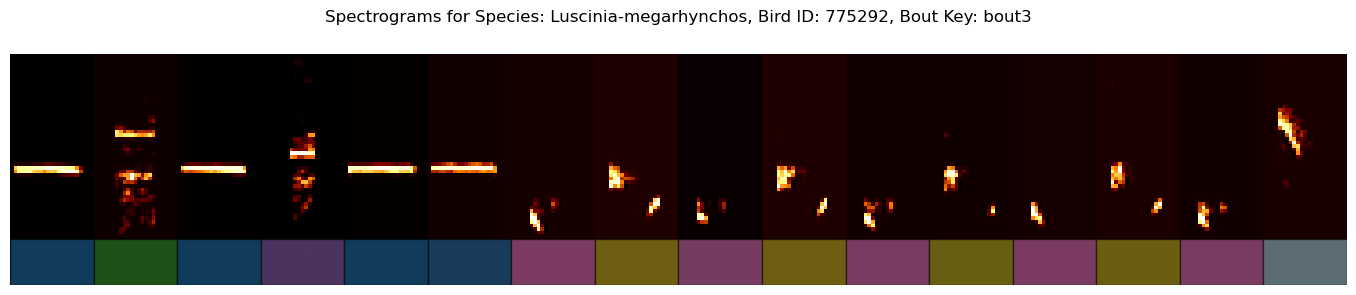

    Bout Key: bout4, Entries: 17
      Drawing spectrograms for Bout Key: bout4...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_bout4_RST.png


<Figure size 5100x200 with 0 Axes>

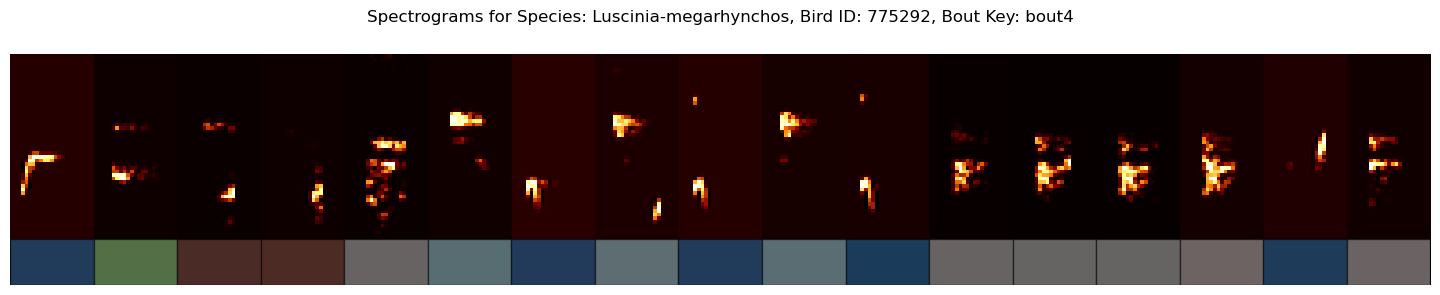

    Bout Key: Bout5, Entries: 12
      Drawing spectrograms for Bout Key: Bout5...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_Bout5_RST.png


<Figure size 3600x200 with 0 Axes>

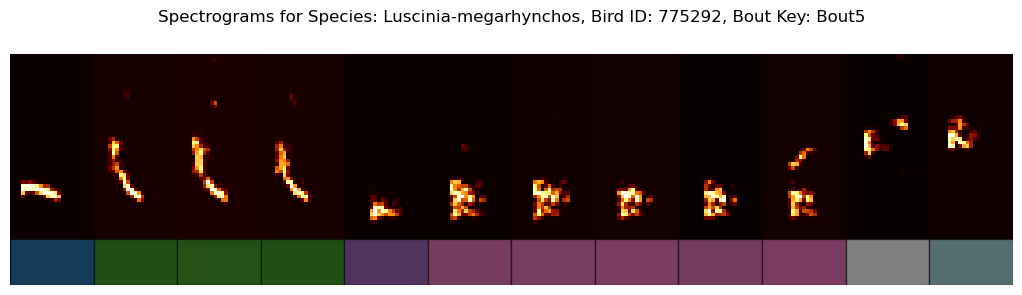

    Bout Key: bout6, Entries: 20
      Drawing spectrograms for Bout Key: bout6...
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Luscinia-megarhynchos_775292_bout6_RST.png


<Figure size 6000x200 with 0 Axes>

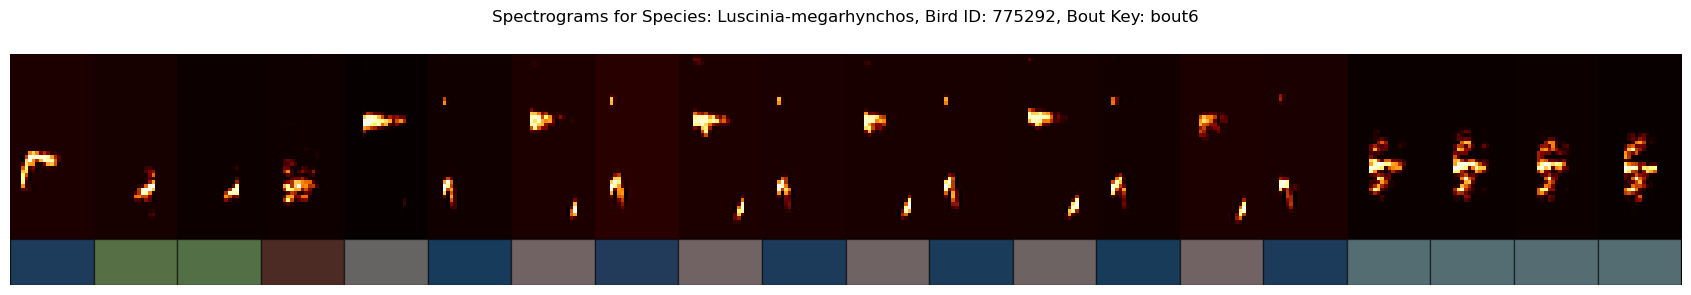

Species: Pipilo-maculatus, Total Entries: 73
  Bird ID: 103315, Entries: 73
    Bout Key: bout1, Entries: 18
      Drawing spectrograms for Bout Key: bout1...
Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Pipilo-maculatus_103315_bout1_RST.png


<Figure size 5400x200 with 0 Axes>

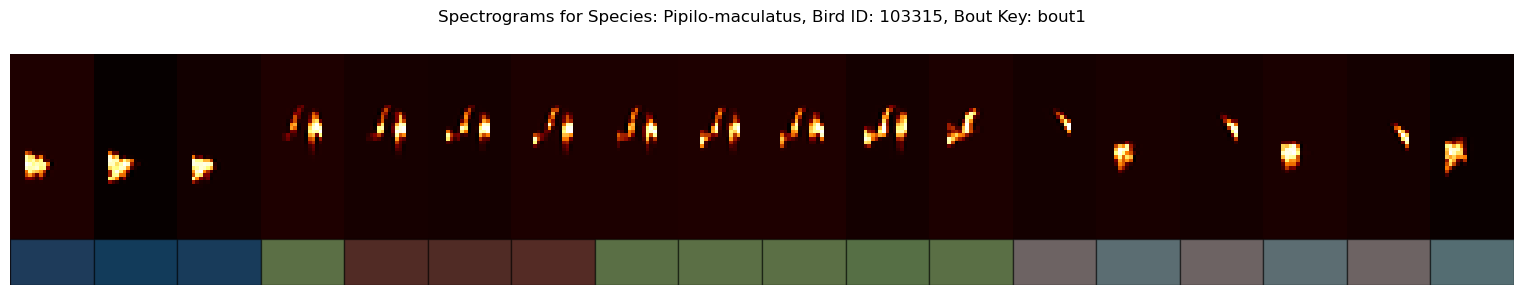

    Bout Key: bout2, Entries: 19
      Drawing spectrograms for Bout Key: bout2...
Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Pipilo-maculatus_103315_bout2_RST.png


<Figure size 5700x200 with 0 Axes>

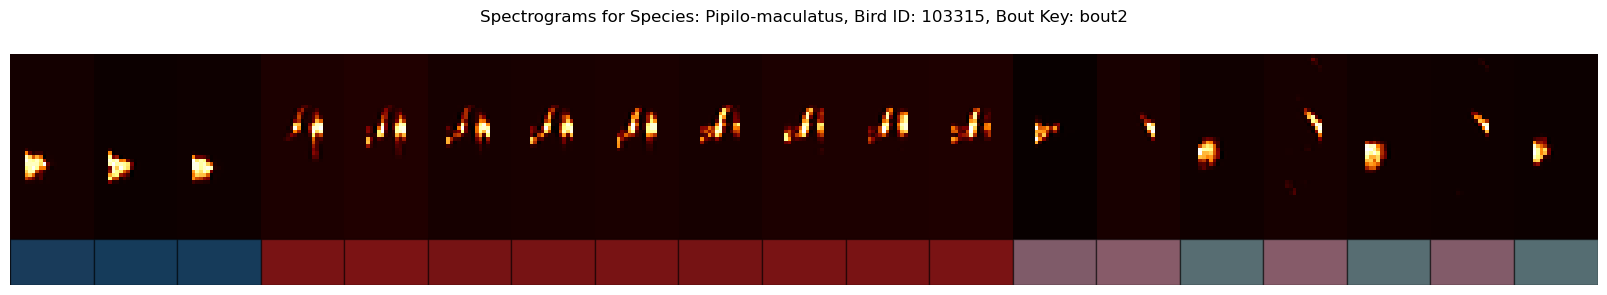

    Bout Key: bout3, Entries: 18
      Drawing spectrograms for Bout Key: bout3...
Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Pipilo-maculatus_103315_bout3_RST.png


<Figure size 5400x200 with 0 Axes>

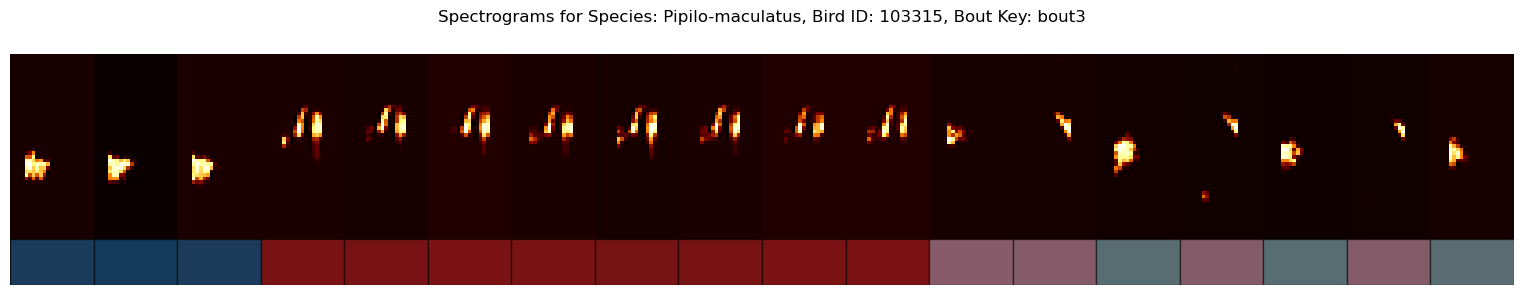

    Bout Key: bout4, Entries: 18
      Drawing spectrograms for Bout Key: bout4...
Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bout\spec_colored_Pipilo-maculatus_103315_bout4_RST.png


<Figure size 5400x200 with 0 Axes>

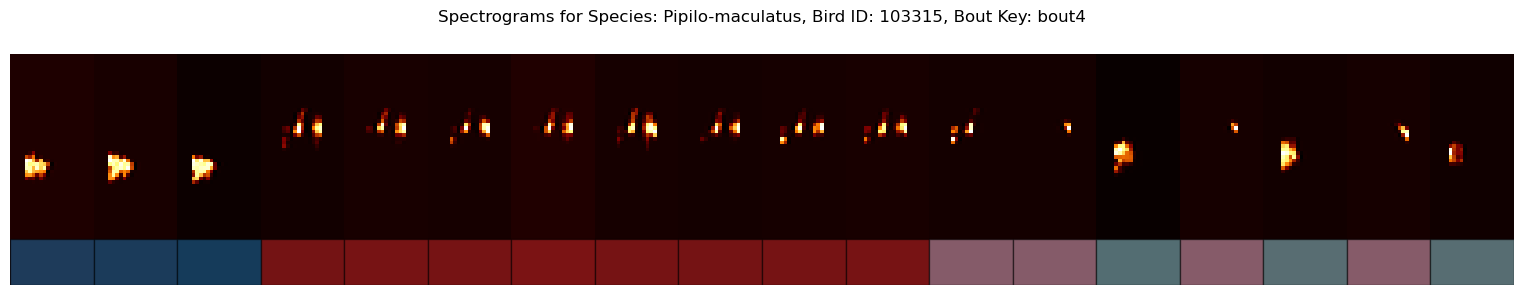

In [11]:
# Generate a color dictionary for hdbscan_labels
def generate_label_colors(unique_labels, default_color="white", cmap_name="tab20"):
    cmap = get_cmap(cmap_name, len(unique_labels))
    label_colors = {label: to_hex(cmap(i)) for i, label in enumerate(unique_labels)}
    label_colors[-1] = default_color  # Assign white to label -1
    return label_colors

# Loop through unique species in the DataFrame
for species in np.sort(syllable_df['species'].unique()):
    species_df = syllable_df[syllable_df['species'] == species]
    print(f"Species: {species}, Total Entries: {len(species_df)}")

    # Loop through each bird_id in the species
    for bird_id in np.sort(species_df['bird_id'].unique()):
        bird_df = species_df[species_df['bird_id'] == bird_id]
        print(f"  Bird ID: {bird_id}, Entries: {len(bird_df)}")

        # Loop through each key (bout) for the bird
        for key in bird_df['key'].unique():
            bout_df = bird_df[bird_df['key'] == key]
            print(f"    Bout Key: {key}, Entries: {len(bout_df)}")

            # Normalize spectrograms and create an array
            specs = np.array([i / np.max(i) if np.max(i) > 0 else i for i in bout_df['spectrogram'].values])
            specs[specs < 0] = 0

            # Generate label colors for the current bout
            unique_labels = bout_df['final_syntax'].unique()
            label_colors = generate_label_colors(unique_labels)

            # Dynamically adjust column width and figure size
            col_width = 3  # Width of a single spectrogram column
            figure_width = col_width * len(bout_df)
            plt.figure(figsize=(figure_width, 2))  # Fixed height of 2 inches

            print(f"      Drawing spectrograms for Bout Key: {key}...")
            draw_spec_set(specs, zoom=3, maxrows=1, colsize=len(bout_df))  # Match colsize to bout_df length

            # Add rectangles to overlay hdbscan_mcs
            ax = plt.gca()
            for idx, row in enumerate(bout_df.itertuples(index=False)):
                color = label_colors[row.final_syntax]
                rect_width = 1 / len(bout_df)  # Adjust rectangle width to match spectrogram
                rect_x = idx * rect_width  # Position the rectangle to align with spectrogram

                # Add the rectangle
                ax.add_patch(
                    mpatches.Rectangle(
                        (rect_x, 0),          # Rectangle starts at (x, y)
                        rect_width,           # Rectangle width
                        0.2,                    # Rectangle height
                        transform=ax.transAxes,  # Use axes coordinates
                        edgecolor="black",       
                        facecolor=color,
                        alpha=0.5,
                    )
                )

            plt.title(f"Spectrograms for Species: {species}, Bird ID: {bird_id}, Bout Key: {key}")
            output_path = os.path.join(output_dir / dataset_id /'spectrograms_colored' / 'by_bout', f"spec_colored_{species}_{bird_id}_{key}_RST.png")
            os.makedirs(output_dir / dataset_id / 'spectrograms_colored'/'by_bout', exist_ok=True)
            plt.savefig(output_path, dpi=300, bbox_inches="tight")
            print(f"Saved figure for Bird ID: {bird_id}, Species: {species} at {output_path}")
            plt.show()

***Saving by Bird***

Species: Junco-hyemalis, Total Entries: 223
  Bird ID: 139623, Entries: 116


C:\Users\ramma\AppData\Local\Temp\ipykernel_12944\932227717.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, len(unique_labels))


Saved figure for Bird ID: 139623, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bird\spec_colored_Junco-hyemalis_139623_RST.png


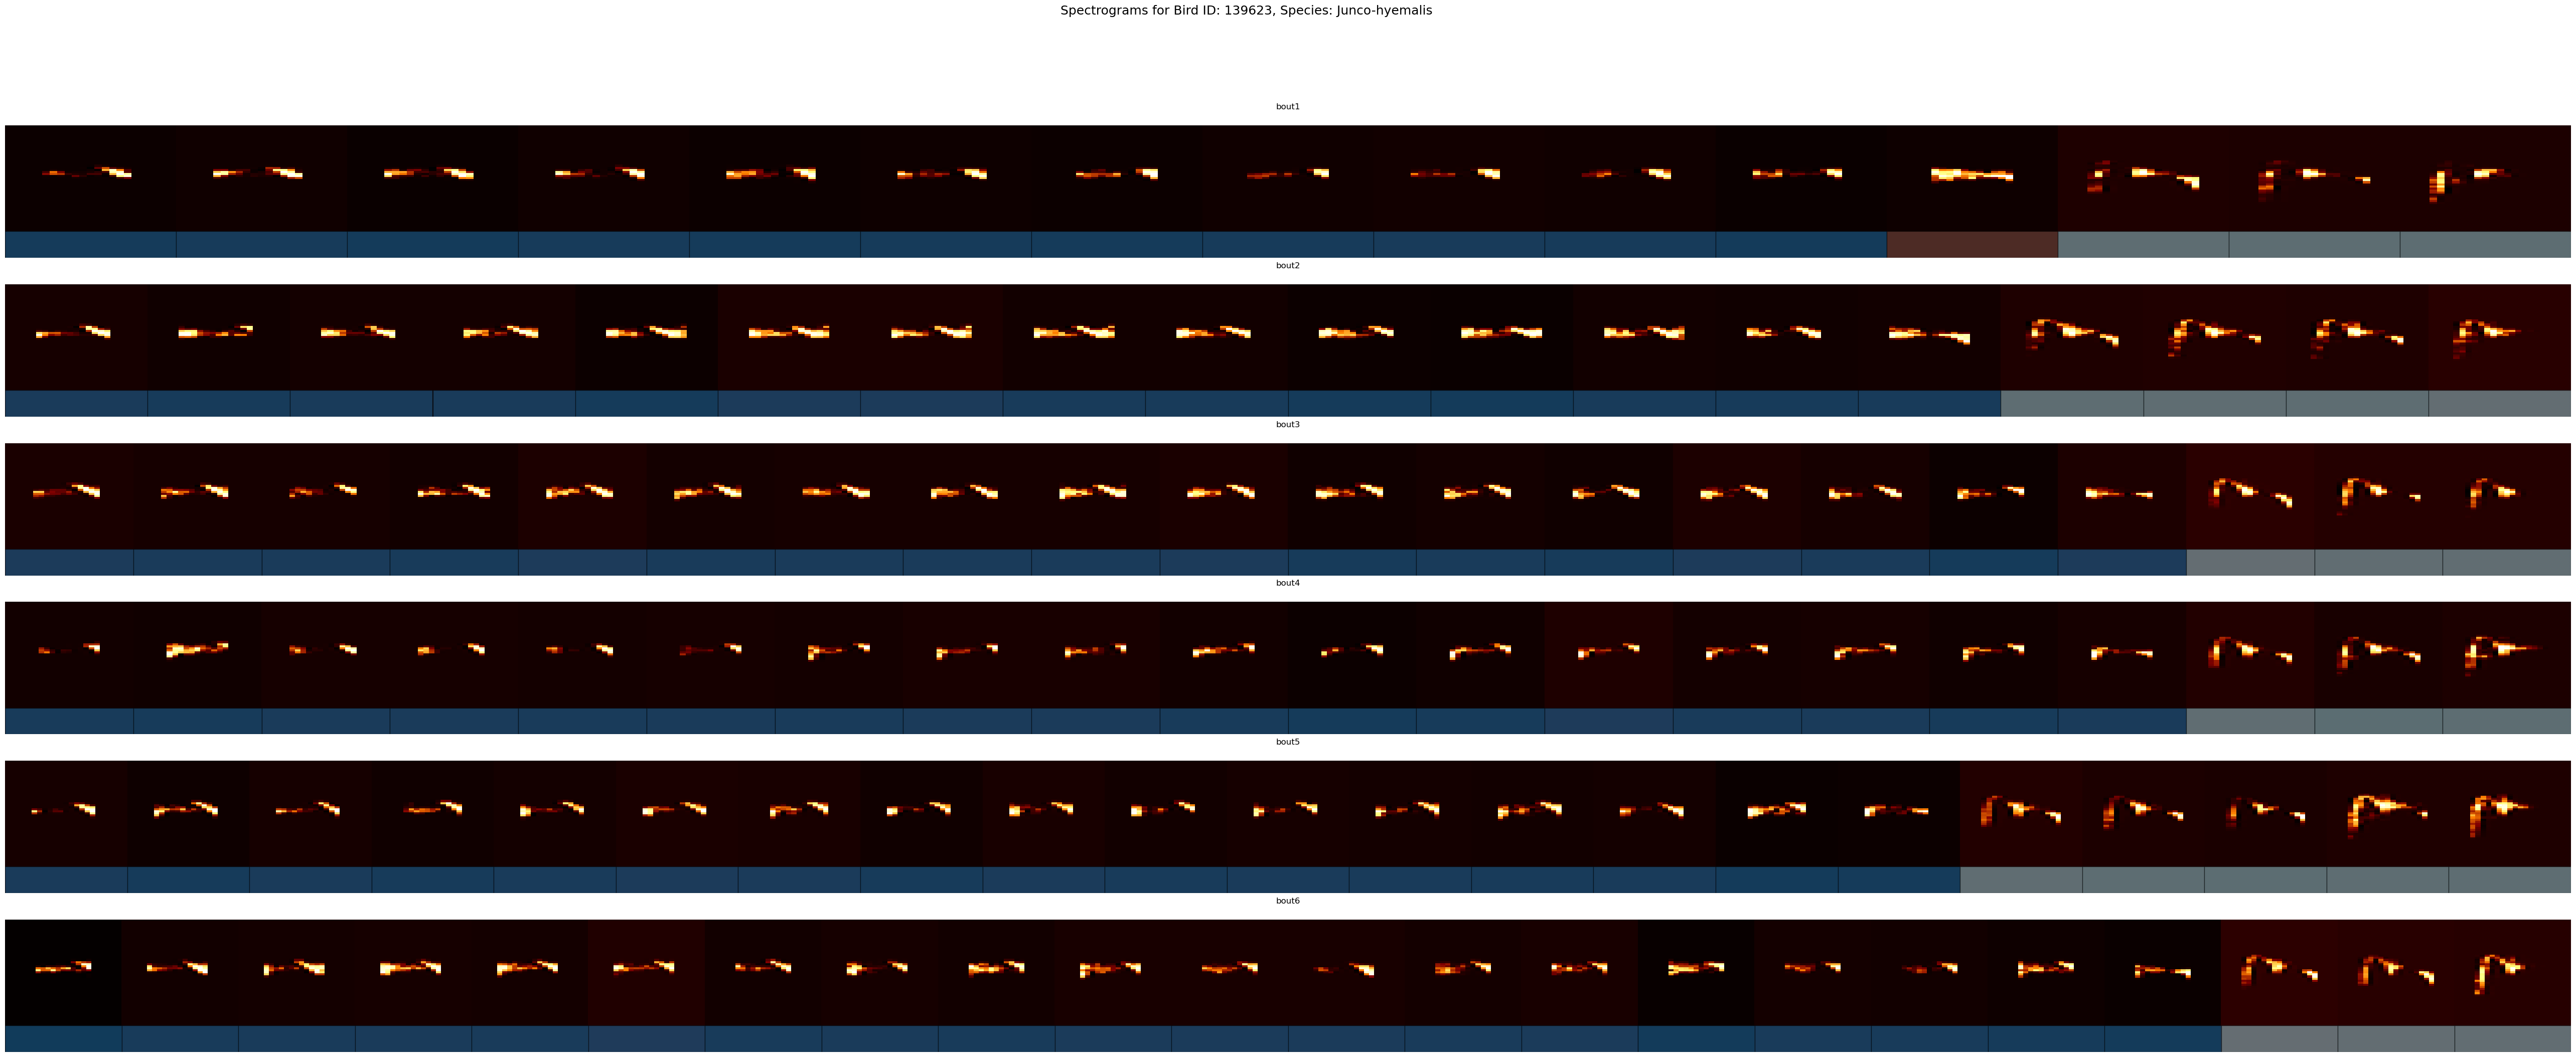

  Bird ID: 79618, Entries: 107
Saved figure for Bird ID: 79618, Species: Junco-hyemalis at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bird\spec_colored_Junco-hyemalis_79618_RST.png


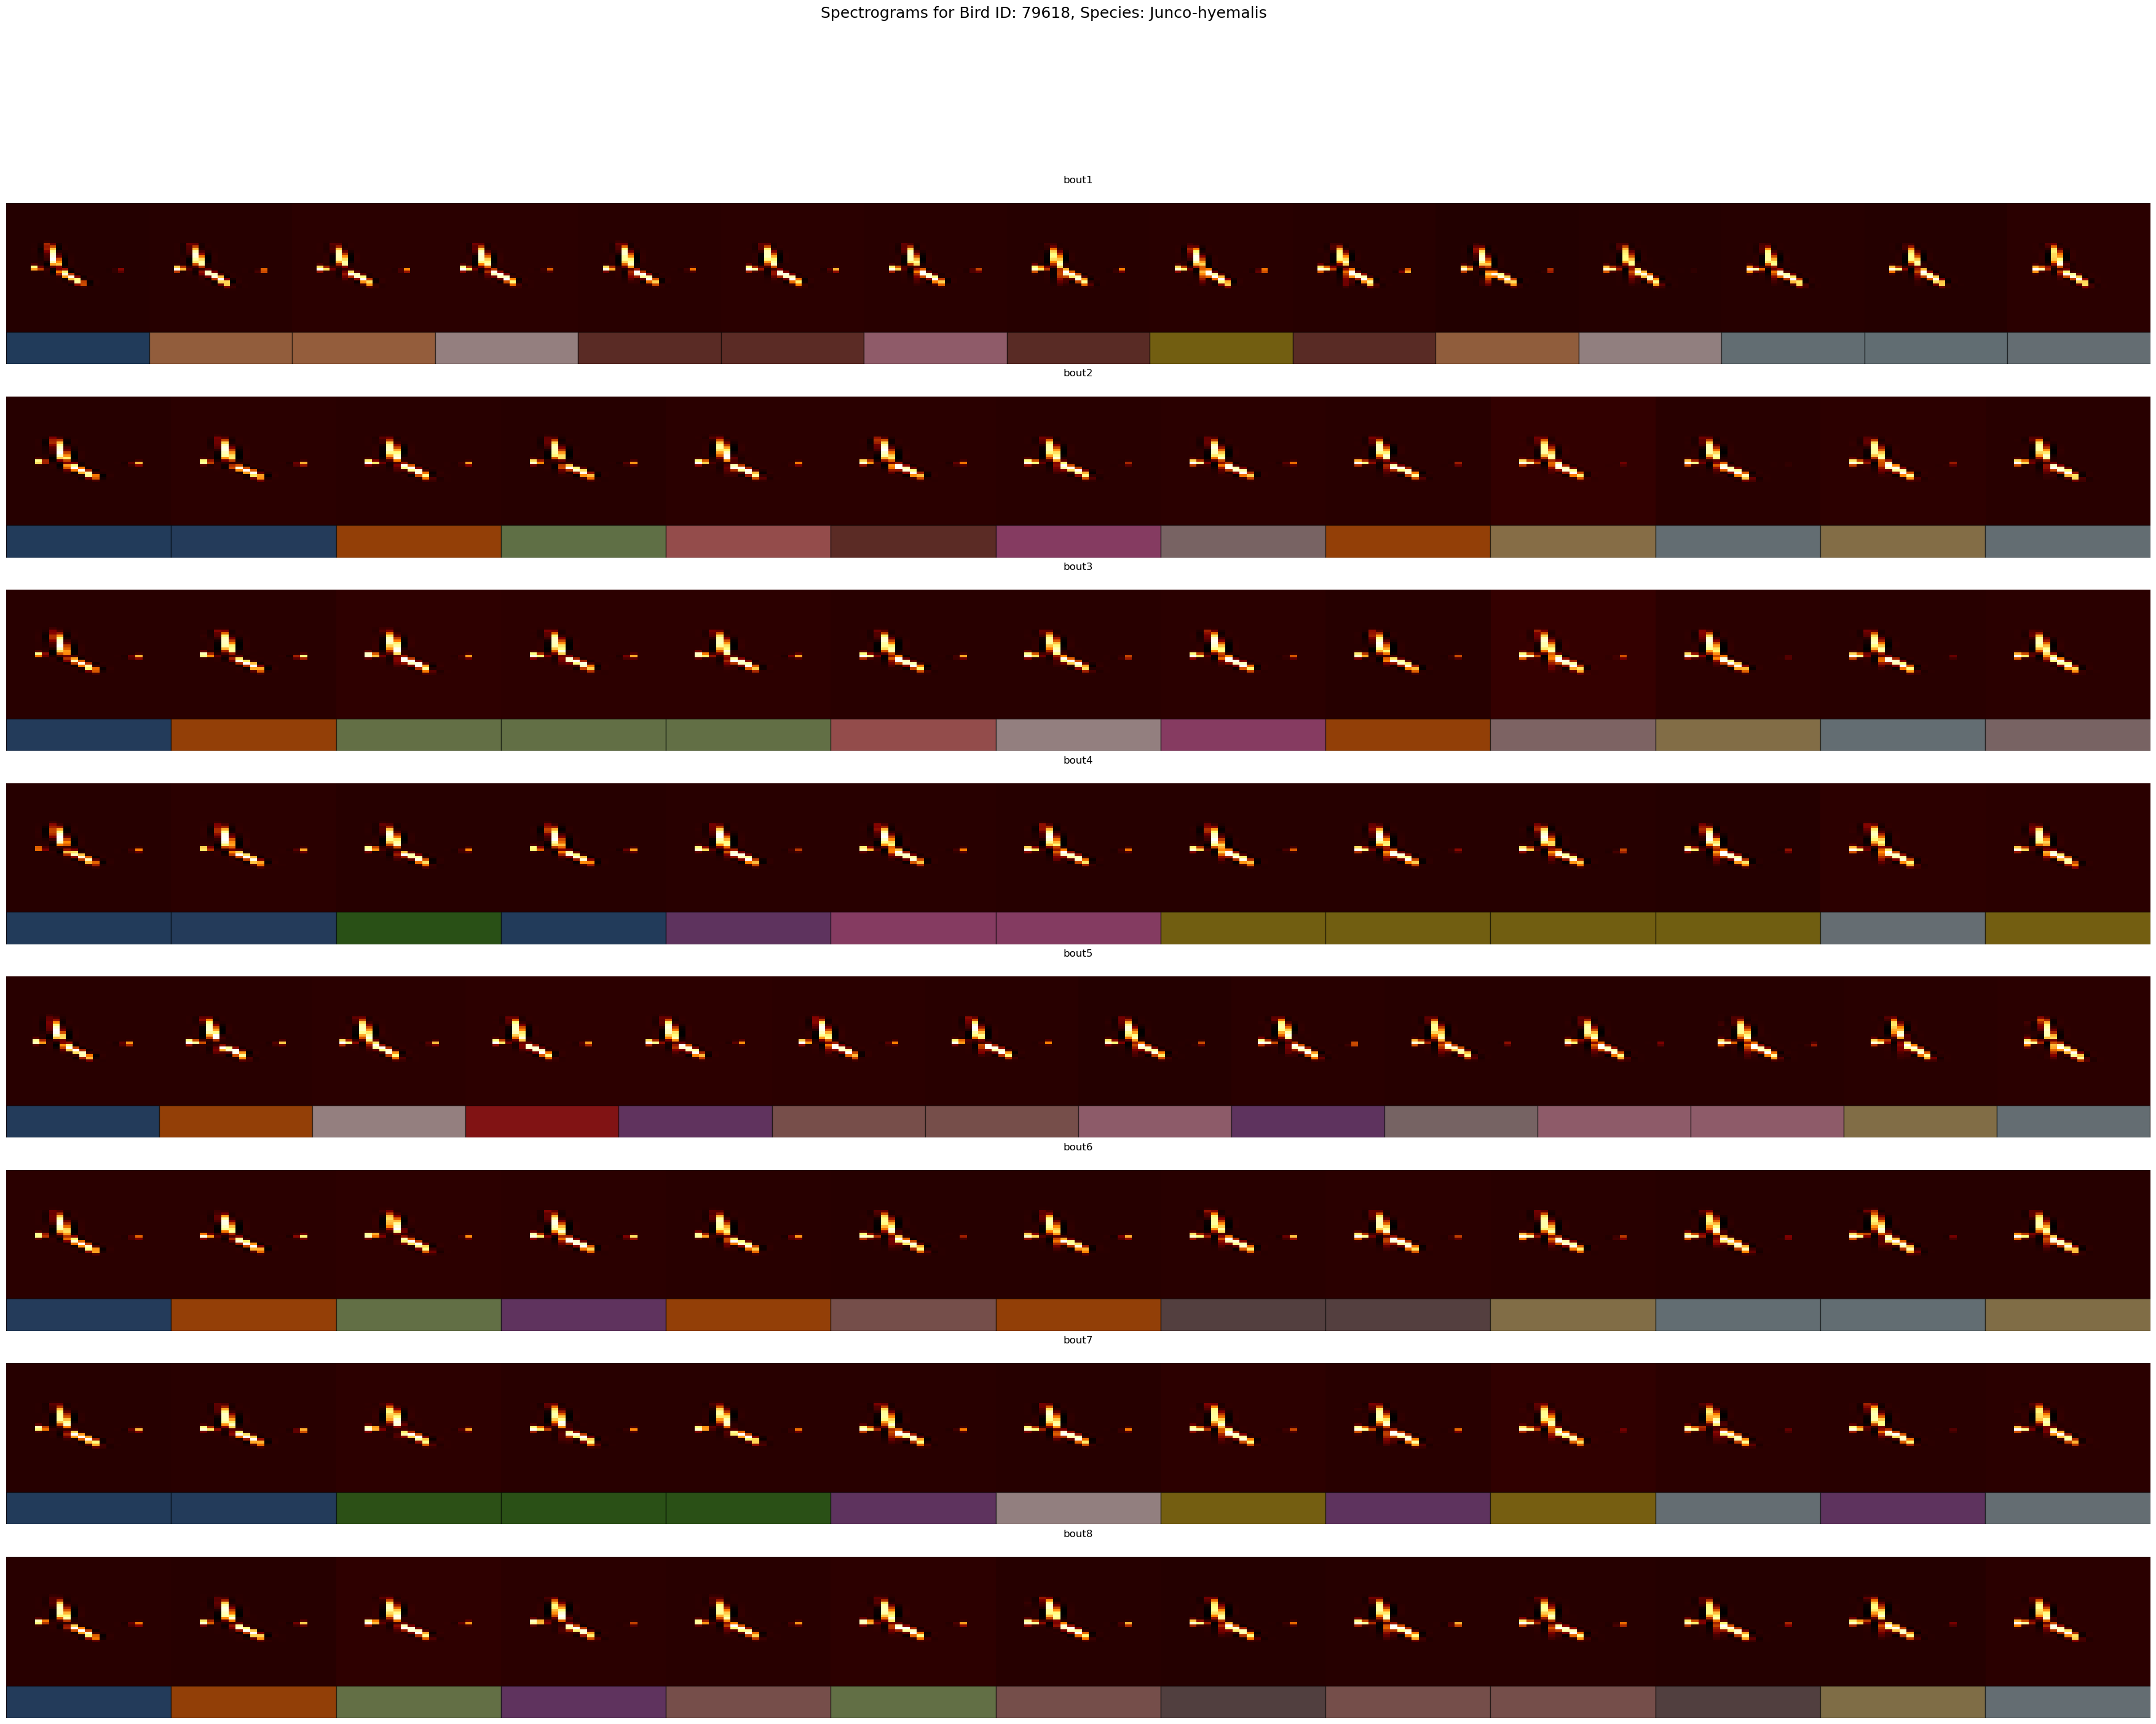

Species: Luscinia-megarhynchos, Total Entries: 106
  Bird ID: 775292, Entries: 106
Saved figure for Bird ID: 775292, Species: Luscinia-megarhynchos at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bird\spec_colored_Luscinia-megarhynchos_775292_RST.png


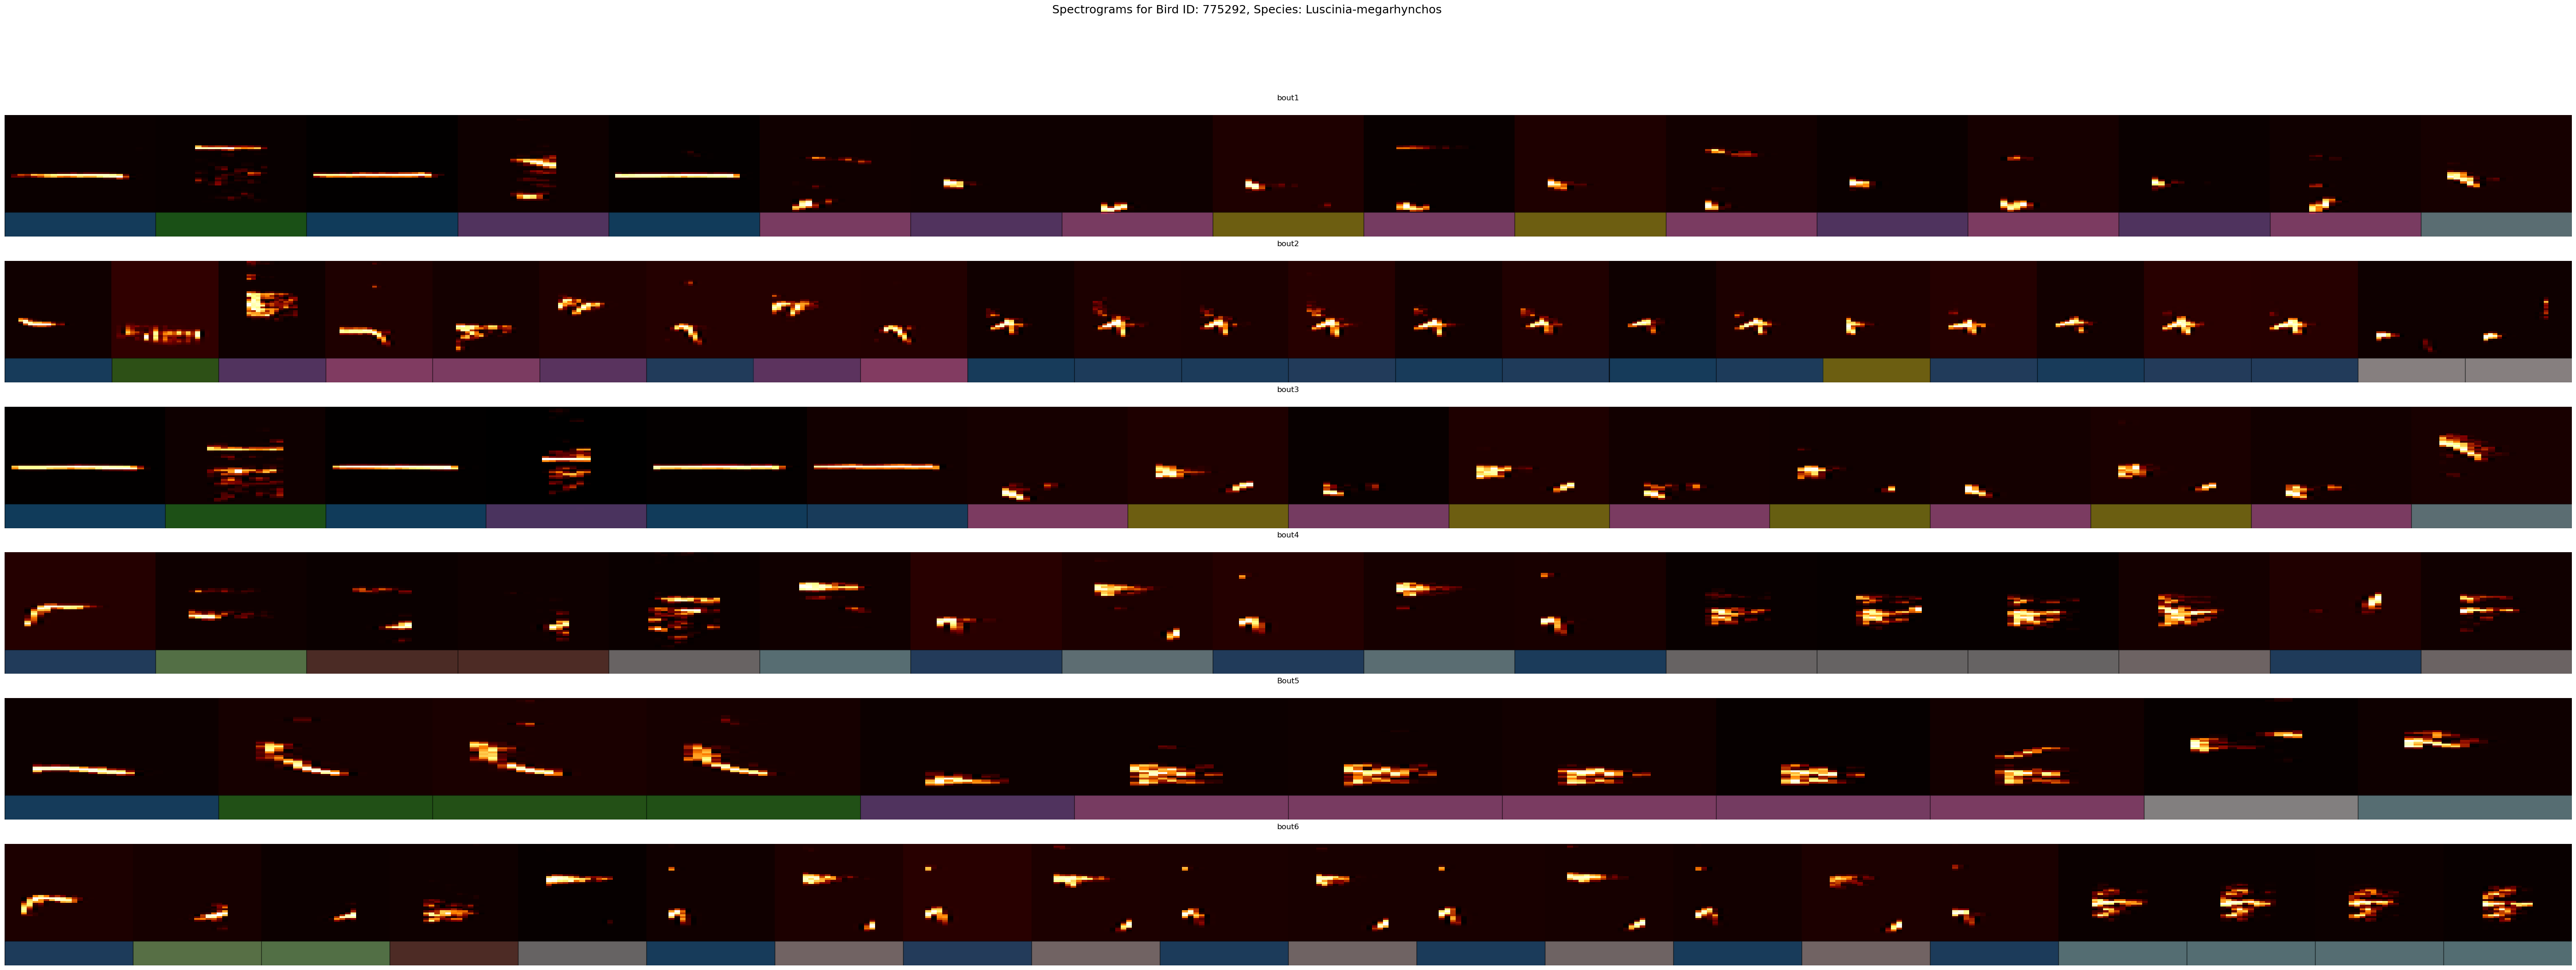

Species: Pipilo-maculatus, Total Entries: 73
  Bird ID: 103315, Entries: 73
Saved figure for Bird ID: 103315, Species: Pipilo-maculatus at C:\Users\ramma\Box\Ram_Ximena_Nicole\Nester_XL_RM\data\output_figures\tutorial-birds\spectrograms_colored\by_bird\spec_colored_Pipilo-maculatus_103315_RST.png


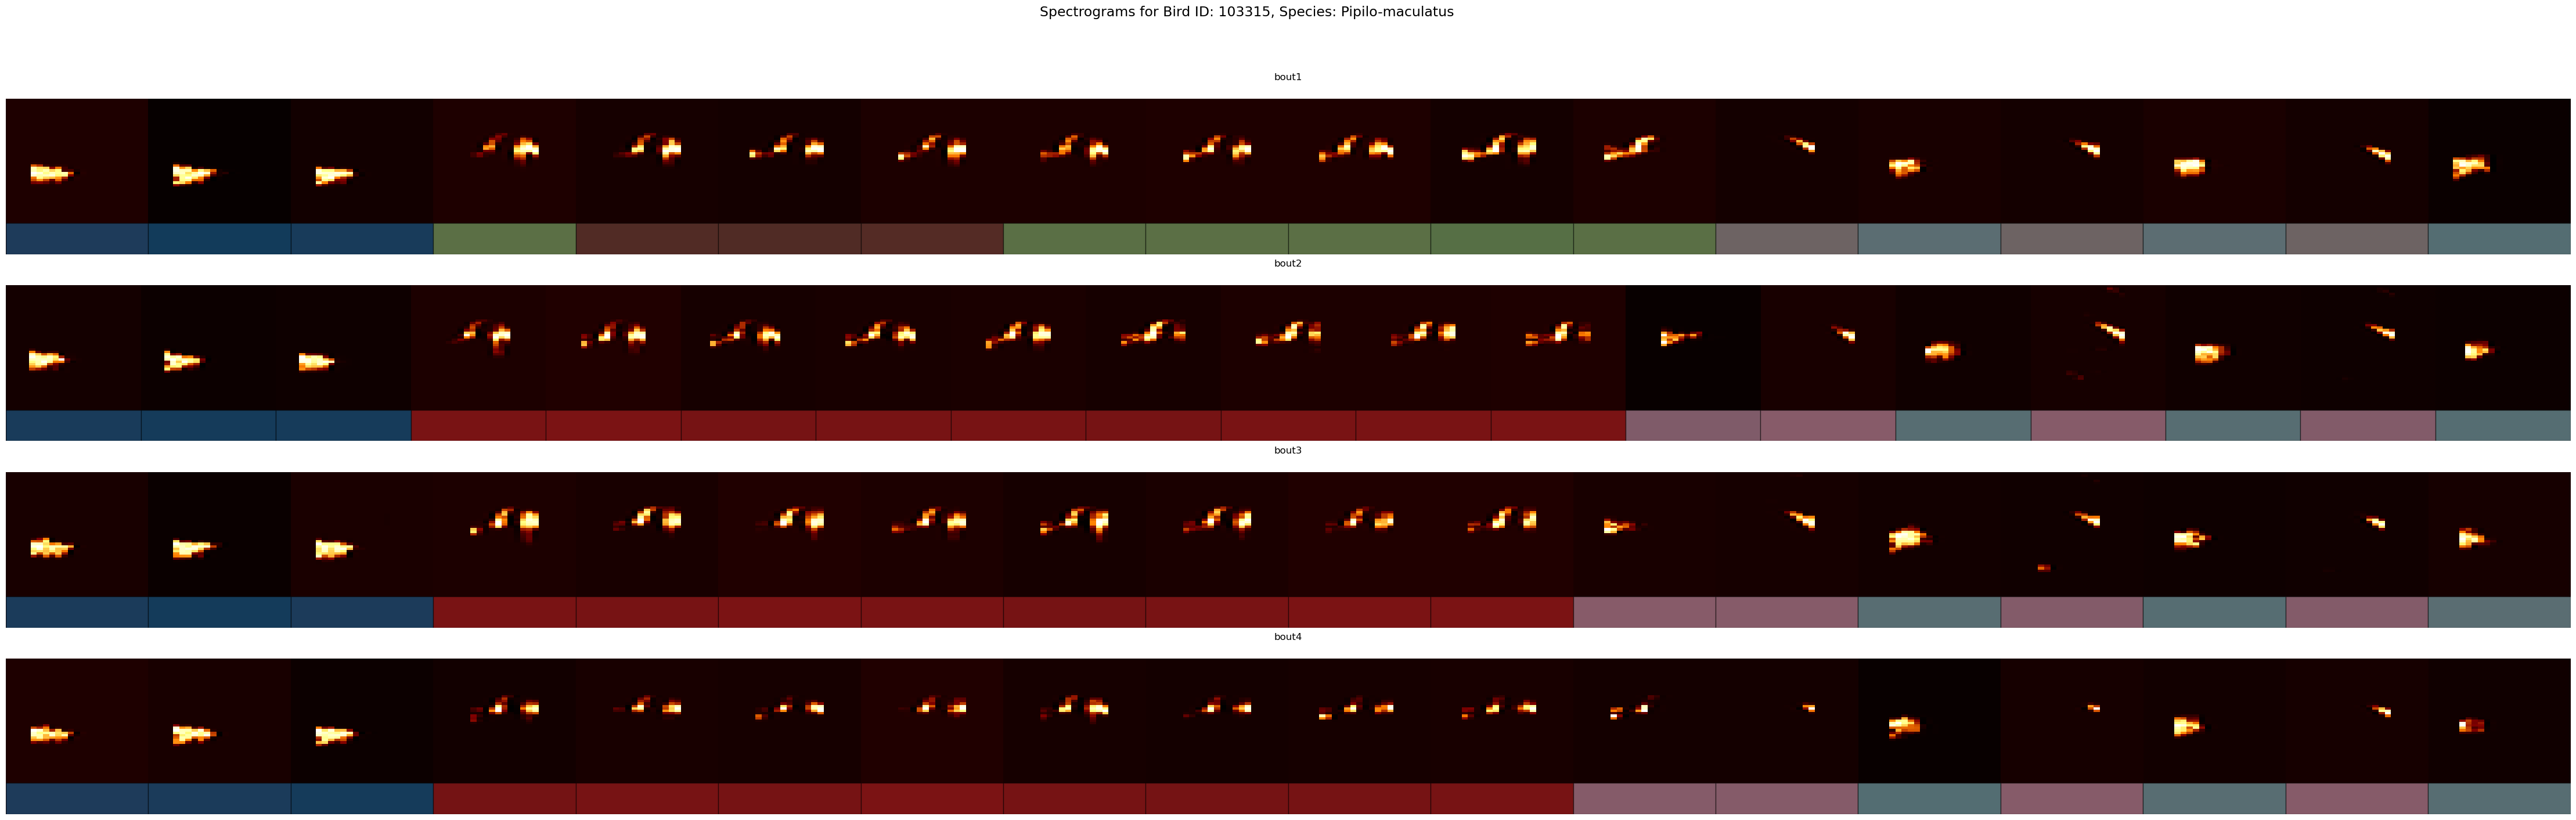

In [12]:
# Saving by Bird 

# Generate a color dictionary for hdbscan_mcs
def generate_label_colors(unique_labels, default_color="white", cmap_name="tab20"):
    cmap = get_cmap(cmap_name, len(unique_labels))
    label_colors = {label: to_hex(cmap(i)) for i, label in enumerate(unique_labels)}
    label_colors[-1] = default_color  # Assign white to label -1
    return label_colors

# Loop through unique species in the DataFrame
for species in np.sort(syllable_df['species'].unique()):
    species_df = syllable_df[syllable_df['species'] == species]
    print(f"Species: {species}, Total Entries: {len(species_df)}")

    # Loop through each bird_id in the species
    for bird_id in np.sort(species_df['bird_id'].unique()):
        bird_df = species_df[species_df['bird_id'] == bird_id]
        print(f"  Bird ID: {bird_id}, Entries: {len(bird_df)}")

        # Collect spectrograms per key for this bird
        key_groups = {key: bird_df.loc[bird_df["key"] == key]for key in bird_df["key"].unique()}


        # Dynamically set figure height based on number of keys
        row_height = 4  # Height per key
        figure_height = row_height * len(key_groups)  
        col_width = 3  # Width of a single spectrogram column
        figure_width = col_width * max(len(group) for group in key_groups.values()) 

        fig, axes = plt.subplots(len(key_groups), 1, figsize=(figure_width, figure_height), squeeze=False)
        num_keys = len(key_groups)
        title_fontsize = max(12, min(20, 16 + num_keys // 3))  # Adjust within a reasonable rang

        # Iterate over each key and plot on a new row
        for idx, (key, bout_df) in enumerate(key_groups.items()):
            specs = np.array([i / np.max(i) if np.max(i) > 0 else i for i in bout_df['spectrogram'].values])
            specs[specs < 0] = 0
            
            unique_labels = bout_df['final_syntax'].unique()
            label_colors = generate_label_colors(unique_labels)

            ax = axes[idx, 0]
            draw_spec_set(specs, zoom=3, maxrows=2, colsize=len(bout_df), ax=ax)

            # Add colored label overlay
            for i, row in enumerate(bout_df.itertuples(index=False)):
                color = label_colors[row.final_syntax]
                rect_width = 1 / len(bout_df)
                rect_x = i * rect_width
                ax.add_patch(mpatches.Rectangle((rect_x, 0), rect_width, 0.2, transform=ax.transAxes, 
                                                 edgecolor="black", facecolor=color, alpha=0.5))
            ax.set_title(f"{key}")

        fig.suptitle(f"Spectrograms for Bird ID: {bird_id}, Species: {species}",fontsize = title_fontsize)
        output_path = os.path.join(output_dir / dataset_id / 'spectrograms_colored' / 'by_bird', f"spec_colored_{species}_{bird_id}_RST.png")
        os.makedirs(output_dir / dataset_id / 'spectrograms_colored'/'by_bird', exist_ok=True)
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure for Bird ID: {bird_id}, Species: {species} at {output_path}")
        plt.show()